In [1]:
import os
import time
import pickle
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, mase_loss, mean_absolute_scaled_error, compute_mase_scale, get_torch_criterion, get_confidence_interval, winkler_score
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Ablation Study on Temporal Features
Precovid Sanity Test (Experiment 1)

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

# Preprocessing Data

In [4]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove_covid=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove_covid:
        # df = df[df['Date'] < ('2019-07-01' if country in ['Hong Kong SAR', 'Chinese Taipei'] else '2020-01-01')]
        df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [5]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1997-01-01 to 2024-07-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            331 non-null    float64
 1   CovidCases                319 non-null    float64
 2   CovidDeaths               319 non-null    float64
 3   FSI                       331 non-null    float64
 4   GDPPerCap                 331 non-null    float64
 5   GDP                       331 non-null    float64
 6   Population                331 non-null    float64
 7   TravelPolicy              331 non-null    float64
 8   Temperature               331 non-null    float64
 9   Precipitation             331 non-null    float64
 10  GlobalCovidTrend          331 non-null    float64
 11  DistFromChina             331 non-null    float64
 12  Country                   331 non-null    object 
 13  GDPRatioChina             331 non-nul

In [6]:
from src.utils import get_seasonal_component, inverse_target
#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove_covid=False):
    all_data = {country: load_data(country, remove_covid=remove_covid) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        all_data[country]['Month'] = all_data[country].index.month.astype(int)
        dummy_month = pd.get_dummies(all_data[country]['Month'].astype(str), prefix='Month', dtype=float)
        all_data[country][dummy_month.columns] = dummy_month
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

In [7]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove_covid=True)

<Axes: xlabel='Date'>

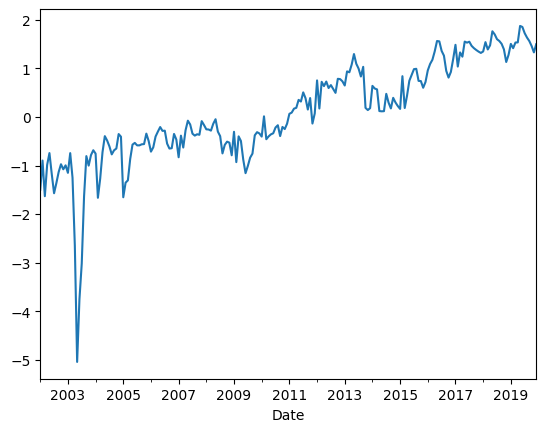

In [8]:
country = 'Singapore'
all_data[country]['VisitorArrivals'].plot()

In [9]:
all_data[country]

,FXAgainstChina,CovidCases,CovidDeaths,FSI,GDPPerCap,GDP,Population,TravelPolicy,Temperature,Precipitation,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,-0.258922,0.0,0.0,-0.701804,-1.933853,-1.681899,-1.598512,0.0,-0.877961,-0.362024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-01,-0.258925,0.0,0.0,-0.701804,-1.910476,-1.669684,-1.594969,0.0,-0.050308,-1.490460,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-03-01,-0.258927,0.0,0.0,-0.701804,-1.887099,-1.657470,-1.591424,0.0,1.108406,-0.913265,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-04-01,-0.258927,0.0,0.0,-0.701804,-1.863722,-1.645255,-1.587880,0.0,1.439467,-0.329842,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2002-05-01,-0.258939,0.0,0.0,-0.701804,-1.840345,-1.633041,-1.584336,0.0,1.936058,-0.115989,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-0.259016,0.0,0.0,-1.024345,1.426329,1.490276,1.360326,0.0,0.942875,-1.415715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-09-01,-0.259024,0.0,0.0,-1.024345,1.400218,1.476286,1.366896,0.0,0.611814,-1.567281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-10-01,-0.259026,0.0,0.0,-1.024345,1.374108,1.462296,1.373464,0.0,-0.050308,-0.212535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
all_data[country].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2002-01-01 to 2019-12-01
Freq: MS
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            216 non-null    float64
 1   CovidCases                216 non-null    float64
 2   CovidDeaths               216 non-null    float64
 3   FSI                       216 non-null    float64
 4   GDPPerCap                 216 non-null    float64
 5   GDP                       216 non-null    float64
 6   Population                216 non-null    float64
 7   TravelPolicy              216 non-null    float64
 8   Temperature               216 non-null    float64
 9   Precipitation             216 non-null    float64
 10  GlobalCovidTrend          216 non-null    float64
 11  DistFromChina             216 non-null    float64
 12  Country                   216 non-null    object 
 13  GDPRatioChina             216 non-nul

# No Temporal Features
### RNN

In [15]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', #'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [16]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)

In [17]:
y_mase_scales = []
for c in country_list:
    f = c + '.csv'
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    for i in range(12, 0, -1):
        y_mase_scales.append(compute_mase_scale(train_y.iloc[:-i].values))

y_mase_scales = np.asarray(y_mase_scales)

In [18]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

Epoch 0: train loss 1.8848, val loss 1.4372, time 1.3655
Epoch 1: train loss 0.9252, val loss 0.9071, time 1.1844
Epoch 2: train loss 0.8177, val loss 0.8606, time 1.1863
Epoch 3: train loss 0.7891, val loss 0.8453, time 1.1915
Epoch 4: train loss 0.7810, val loss 0.8266, time 1.1792
Epoch 5: train loss 0.7426, val loss 0.8247, time 1.1866
Epoch 6: train loss 0.7376, val loss 0.8301, time 1.1837
Epoch 7: train loss 0.7299, val loss 0.8056, time 1.1855
Epoch 8: train loss 0.7180, val loss 0.8123, time 1.1987
Epoch 9: train loss 0.7076, val loss 0.7953, time 1.1900
Epoch 10: train loss 0.7119, val loss 1.0226, time 1.1910
Epoch 11: train loss 0.7056, val loss 0.8368, time 1.1850
Epoch 12: train loss 0.7028, val loss 0.9016, time 1.1907
Epoch 13: train loss 0.7000, val loss 0.9268, time 1.1920
Early stopping as no improvement in val loss


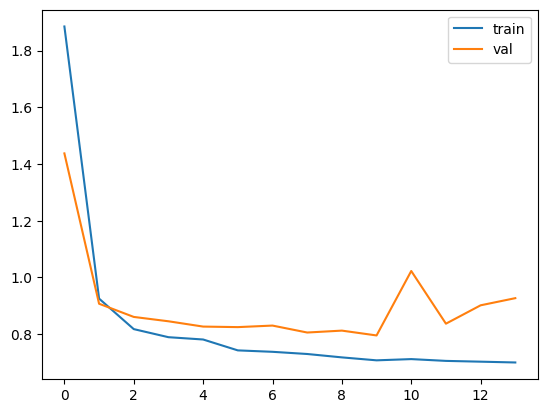

In [29]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=16, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [30]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [31]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [32]:
all_y = rnn_gt

In [33]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 403946.50616
RNN R2: 0.81158
RNN MAE: 114888.26272
RNN MAPE: 0.25794
RNN MASE: 2.55218


## One Step RNN

In [55]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', #'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 1.2826, val loss 0.6719, time 1.5824
Epoch 1: train loss 0.7934, val loss 0.7316, time 1.3990
Epoch 2: train loss 0.6037, val loss 0.7825, time 1.4005
Epoch 3: train loss 0.5767, val loss 0.5056, time 1.3949
Epoch 4: train loss 0.5434, val loss 0.5176, time 1.3986
Epoch 5: train loss 0.5432, val loss 0.6394, time 1.3971
Epoch 6: train loss 0.5356, val loss 0.4782, time 1.4248
Epoch 7: train loss 0.5438, val loss 0.5988, time 1.3894
Epoch 8: train loss 0.5494, val loss 0.5115, time 1.3942
Epoch 9: train loss 0.5392, val loss 0.6538, time 1.4039
Epoch 10: train loss 0.5214, val loss 0.5783, time 1.3941
Epoch 11: train loss 0.5204, val loss 0.6082, time 1.3894
Epoch 12: train loss 0.5253, val loss 0.4807, time 1.3900
Epoch 13: train loss 0.5039, val loss 0.5249, time 1.3980
Early stopping as no improvement in val loss


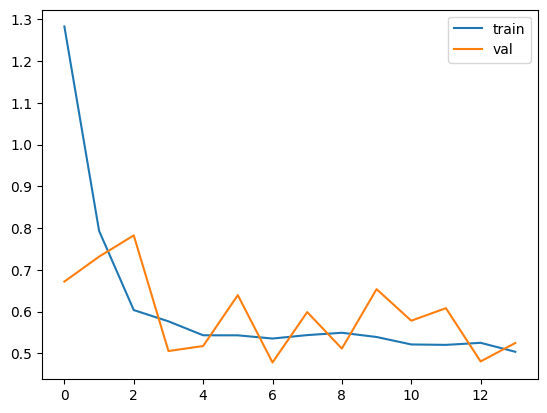

In [56]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=16, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [57]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [58]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [59]:
(rnn_gt == all_y).all()

True

In [60]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 313510.20339
RNN R2: 0.88650
RNN MAE: 85903.52071
RNN MAPE: 0.21186
RNN MASE: 2.17813


### Separate RNN models

In [63]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest',# 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 2.7533, val loss 6.2688, time 0.0710
Epoch 1: train loss 2.7334, val loss 6.1548, time 0.0613
Epoch 2: train loss 2.6255, val loss 6.0296, time 0.0613
Epoch 3: train loss 2.5706, val loss 5.8916, time 0.0616
Epoch 4: train loss 2.5053, val loss 5.7402, time 0.0630
Epoch 5: train loss 2.4655, val loss 5.5723, time 0.0618
Epoch 6: train loss 2.3668, val loss 5.3743, time 0.0619
Epoch 7: train loss 2.2785, val loss 5.1393, time 0.0614
Epoch 8: train loss 2.1833, val loss 4.8767, time 0.0612
Epoch 9: train loss 2.0568, val loss 4.5742, time 0.0609
Epoch 10: train loss 1.8863, val loss 4.2433, time 0.0598
Epoch 11: train loss 1.7404, val loss 3.8978, time 0.0604
Epoch 12: train loss 1.6694, val loss 3.5689, time 0.0624
Epoch 13: train loss 1.5085, val loss 3.2455, time 0.0619
Epoch 14: train loss 1.4338, val loss 2.9521, time 0.0617
Epoch 15: train loss 1.3469, val loss 2.7017, time 0.0612
Epoch 16: train loss 1.2823, val loss 2.5118, time 0.0620
Epoch 17: train l

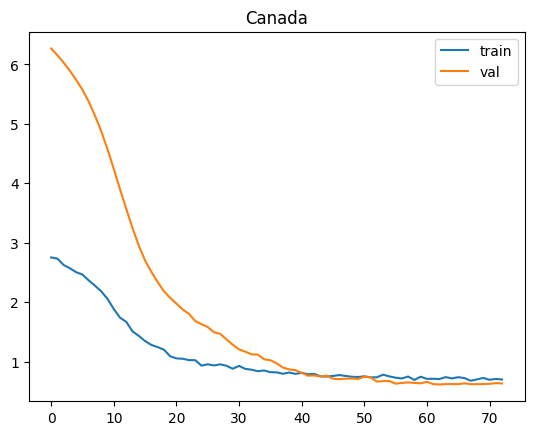

Chile
Epoch 0: train loss 2.2906, val loss 3.1587, time 0.0221
Epoch 1: train loss 2.2876, val loss 3.1463, time 0.0199
Epoch 2: train loss 2.2681, val loss 3.1356, time 0.0191
Epoch 3: train loss 2.2747, val loss 3.1252, time 0.0197
Epoch 4: train loss 2.2620, val loss 3.1096, time 0.0194
Epoch 5: train loss 2.2593, val loss 3.0966, time 0.0192
Epoch 6: train loss 2.2527, val loss 3.0804, time 0.0200
Epoch 7: train loss 2.2299, val loss 3.0684, time 0.0193
Epoch 8: train loss 2.2207, val loss 3.0548, time 0.0193
Epoch 9: train loss 2.2092, val loss 3.0400, time 0.0192
Epoch 10: train loss 2.2281, val loss 3.0239, time 0.0191
Epoch 11: train loss 2.2145, val loss 3.0067, time 0.0187
Epoch 12: train loss 2.1864, val loss 2.9897, time 0.0199
Epoch 13: train loss 2.1858, val loss 2.9748, time 0.0187
Epoch 14: train loss 2.1513, val loss 2.9565, time 0.0187
Epoch 15: train loss 2.1299, val loss 2.9376, time 0.0188
Epoch 16: train loss 2.1570, val loss 2.9201, time 0.0189
Epoch 17: train lo

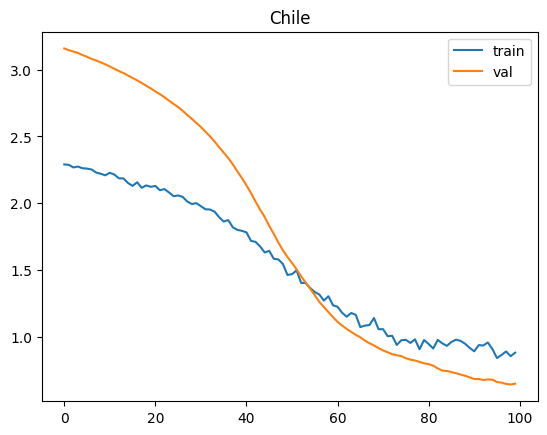

Mexico
Epoch 0: train loss 2.2358, val loss 4.8023, time 0.0576
Epoch 1: train loss 2.4654, val loss 4.7230, time 0.0502
Epoch 2: train loss 2.0171, val loss 4.6475, time 0.0503
Epoch 3: train loss 1.8330, val loss 4.5918, time 0.0504
Epoch 4: train loss 2.2679, val loss 4.4779, time 0.0507
Epoch 5: train loss 2.1626, val loss 4.3815, time 0.0502
Epoch 6: train loss 1.8676, val loss 4.2733, time 0.0515
Epoch 7: train loss 1.7648, val loss 4.1494, time 0.0508
Epoch 8: train loss 1.8671, val loss 4.0028, time 0.0510
Epoch 9: train loss 1.9292, val loss 3.8244, time 0.0505
Epoch 10: train loss 1.7308, val loss 3.6492, time 0.0503
Epoch 11: train loss 1.7645, val loss 3.4474, time 0.0501
Epoch 12: train loss 1.5071, val loss 3.2460, time 0.0504
Epoch 13: train loss 1.5369, val loss 3.0469, time 0.0510
Epoch 14: train loss 1.3595, val loss 2.8584, time 0.0499
Epoch 15: train loss 1.2517, val loss 2.7055, time 0.0500
Epoch 16: train loss 1.2478, val loss 2.5516, time 0.0508
Epoch 17: train l

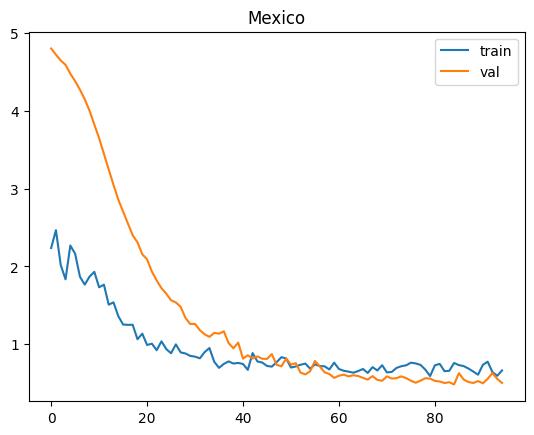

Chinese Taipei
Epoch 0: train loss 0.9790, val loss 1.5355, time 0.0400
Epoch 1: train loss 0.9849, val loss 1.5297, time 0.0353
Epoch 2: train loss 0.9165, val loss 1.5235, time 0.0355
Epoch 3: train loss 0.9331, val loss 1.5201, time 0.0351
Epoch 4: train loss 0.9268, val loss 1.5134, time 0.0350
Epoch 5: train loss 0.9285, val loss 1.5078, time 0.0351
Epoch 6: train loss 0.8958, val loss 1.5025, time 0.0357
Epoch 7: train loss 0.9365, val loss 1.4929, time 0.0345
Epoch 8: train loss 0.8915, val loss 1.4889, time 0.0365
Epoch 9: train loss 0.8701, val loss 1.4853, time 0.0348
Epoch 10: train loss 0.8744, val loss 1.4817, time 0.0347
Epoch 11: train loss 0.8089, val loss 1.4765, time 0.0346
Epoch 12: train loss 0.7988, val loss 1.4730, time 0.0358
Epoch 13: train loss 0.8039, val loss 1.4705, time 0.0345
Epoch 14: train loss 0.7803, val loss 1.4641, time 0.0351
Epoch 15: train loss 0.7898, val loss 1.4590, time 0.0342
Epoch 16: train loss 0.7803, val loss 1.4500, time 0.0341
Epoch 17:

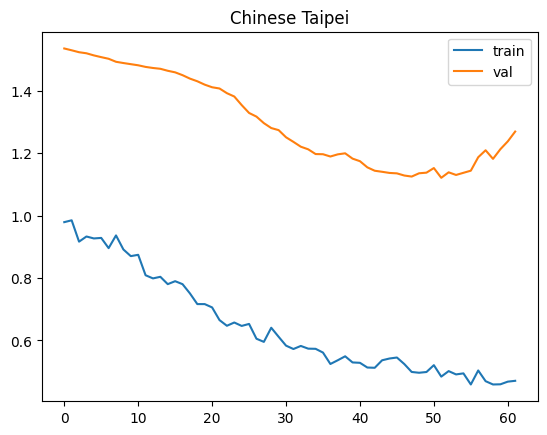

Hong Kong SAR
Epoch 0: train loss 3.0632, val loss 4.5679, time 0.0844
Epoch 1: train loss 2.9485, val loss 4.3983, time 0.0766
Epoch 2: train loss 2.9305, val loss 4.1761, time 0.0761
Epoch 3: train loss 2.7910, val loss 3.9389, time 0.0763
Epoch 4: train loss 2.5954, val loss 3.6868, time 0.0759
Epoch 5: train loss 2.4920, val loss 3.4415, time 0.0752
Epoch 6: train loss 2.4492, val loss 3.1396, time 0.0756
Epoch 7: train loss 2.2368, val loss 2.9082, time 0.0752
Epoch 8: train loss 1.9003, val loss 2.6921, time 0.0751
Epoch 9: train loss 1.7669, val loss 2.4971, time 0.0779
Epoch 10: train loss 1.6931, val loss 2.3410, time 0.0750
Epoch 11: train loss 1.5474, val loss 2.2206, time 0.0745
Epoch 12: train loss 1.2593, val loss 2.1121, time 0.0750
Epoch 13: train loss 1.1578, val loss 2.0335, time 0.0845
Epoch 14: train loss 1.1031, val loss 1.9438, time 0.0743
Epoch 15: train loss 0.9939, val loss 1.8932, time 0.0747
Epoch 16: train loss 1.0161, val loss 1.8452, time 0.0760
Epoch 17: 

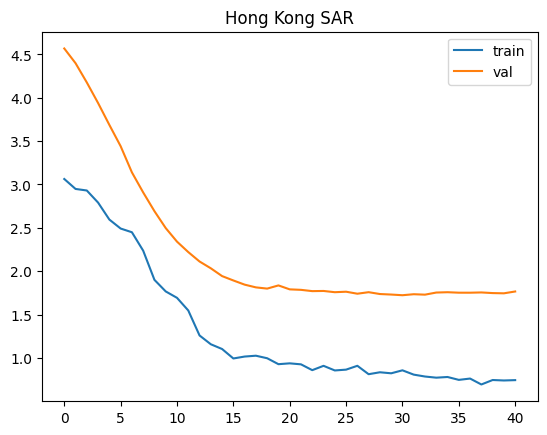

Japan
Epoch 0: train loss 4.7349, val loss 8.4845, time 0.0951
Epoch 1: train loss 4.5727, val loss 8.4119, time 0.0841
Epoch 2: train loss 4.5219, val loss 8.3273, time 0.0834
Epoch 3: train loss 4.3096, val loss 8.2327, time 0.0858
Epoch 4: train loss 4.0793, val loss 8.1277, time 0.0835
Epoch 5: train loss 3.9620, val loss 8.0016, time 0.0834
Epoch 6: train loss 3.7773, val loss 7.8568, time 0.0843
Epoch 7: train loss 3.6513, val loss 7.6877, time 0.0831
Epoch 8: train loss 3.5542, val loss 7.4821, time 0.0836
Epoch 9: train loss 3.3336, val loss 7.2386, time 0.0846
Epoch 10: train loss 3.1043, val loss 6.9769, time 0.0834
Epoch 11: train loss 3.0188, val loss 6.7112, time 0.0834
Epoch 12: train loss 2.8195, val loss 6.4278, time 0.0841
Epoch 13: train loss 2.6034, val loss 6.1579, time 0.0836
Epoch 14: train loss 2.4403, val loss 5.9046, time 0.0838
Epoch 15: train loss 2.3589, val loss 5.6860, time 0.0838
Epoch 16: train loss 2.2730, val loss 5.4623, time 0.0828
Epoch 17: train lo

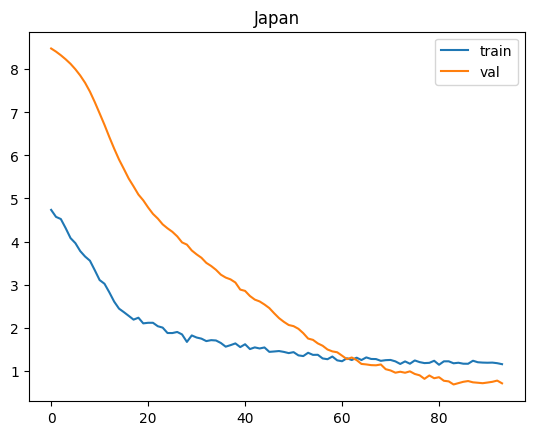

Korea (ROK)
Epoch 0: train loss 3.2419, val loss 5.2735, time 0.0905
Epoch 1: train loss 3.2300, val loss 5.1297, time 0.0776
Epoch 2: train loss 3.0937, val loss 4.9741, time 0.0779
Epoch 3: train loss 3.1072, val loss 4.7974, time 0.0782
Epoch 4: train loss 2.9672, val loss 4.6037, time 0.0802
Epoch 5: train loss 2.8493, val loss 4.4018, time 0.0801
Epoch 6: train loss 2.8619, val loss 4.1590, time 0.0809
Epoch 7: train loss 2.5669, val loss 3.8843, time 0.0797
Epoch 8: train loss 2.4262, val loss 3.5785, time 0.0789
Epoch 9: train loss 2.2536, val loss 3.2241, time 0.0798
Epoch 10: train loss 2.0617, val loss 2.8397, time 0.0799
Epoch 11: train loss 1.8698, val loss 2.4721, time 0.0802
Epoch 12: train loss 1.7044, val loss 2.1044, time 0.0813
Epoch 13: train loss 1.5812, val loss 1.7688, time 0.0804
Epoch 14: train loss 1.5273, val loss 1.4706, time 0.0806
Epoch 15: train loss 1.3896, val loss 1.2566, time 0.0793
Epoch 16: train loss 1.2775, val loss 1.1419, time 0.0800
Epoch 17: tr

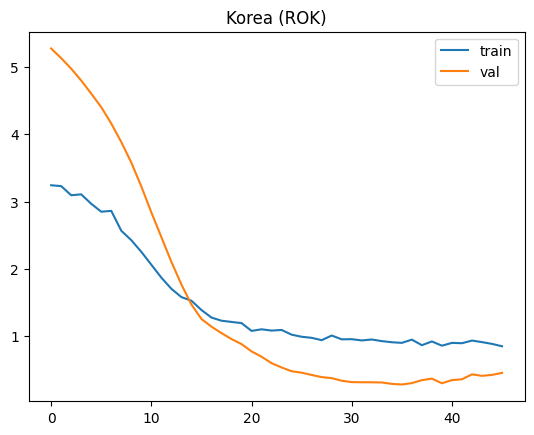

Macao, China
Epoch 0: train loss 2.0389, val loss 5.3077, time 0.0869
Epoch 1: train loss 2.0727, val loss 5.1674, time 0.0761
Epoch 2: train loss 1.9376, val loss 5.0323, time 0.0762
Epoch 3: train loss 2.0054, val loss 4.8739, time 0.0787
Epoch 4: train loss 1.6929, val loss 4.7324, time 0.0758
Epoch 5: train loss 1.7659, val loss 4.5631, time 0.0757
Epoch 6: train loss 1.7309, val loss 4.3713, time 0.0767
Epoch 7: train loss 1.6928, val loss 4.1490, time 0.0764
Epoch 8: train loss 1.4789, val loss 3.9325, time 0.0771
Epoch 9: train loss 1.5149, val loss 3.6535, time 0.0778
Epoch 10: train loss 1.3581, val loss 3.3475, time 0.0758
Epoch 11: train loss 1.3916, val loss 3.0134, time 0.0760
Epoch 12: train loss 1.2514, val loss 2.6498, time 0.0760
Epoch 13: train loss 1.1325, val loss 2.3512, time 0.0749
Epoch 14: train loss 1.0273, val loss 2.0688, time 0.0739
Epoch 15: train loss 0.9706, val loss 1.7828, time 0.0749
Epoch 16: train loss 0.9041, val loss 1.6570, time 0.0762
Epoch 17: t

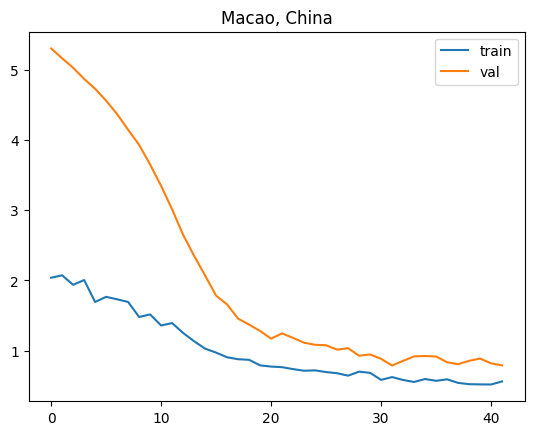

Maldives
Epoch 0: train loss 2.4960, val loss 3.9046, time 0.0893
Epoch 1: train loss 2.5717, val loss 3.7940, time 0.0801
Epoch 2: train loss 2.4376, val loss 3.6672, time 0.0803
Epoch 3: train loss 2.4448, val loss 3.5273, time 0.0807
Epoch 4: train loss 2.3163, val loss 3.3619, time 0.0790
Epoch 5: train loss 2.3190, val loss 3.1593, time 0.0780
Epoch 6: train loss 2.2163, val loss 2.9142, time 0.0787
Epoch 7: train loss 2.1165, val loss 2.6223, time 0.0787
Epoch 8: train loss 1.9799, val loss 2.3338, time 0.0807
Epoch 9: train loss 1.9078, val loss 2.0249, time 0.0797
Epoch 10: train loss 1.7174, val loss 1.6734, time 0.0800
Epoch 11: train loss 1.5529, val loss 1.3755, time 0.0783
Epoch 12: train loss 1.4016, val loss 1.1384, time 0.0793
Epoch 13: train loss 1.2585, val loss 0.9881, time 0.0777
Epoch 14: train loss 1.1131, val loss 0.8120, time 0.0800
Epoch 15: train loss 1.0315, val loss 0.6637, time 0.0802
Epoch 16: train loss 0.9914, val loss 0.5850, time 0.0789
Epoch 17: train

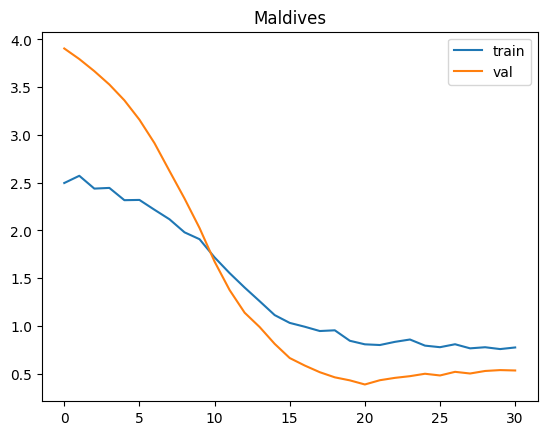

Cambodia
Epoch 0: train loss 3.1069, val loss 7.6521, time 0.0681
Epoch 1: train loss 3.0251, val loss 7.5391, time 0.0588
Epoch 2: train loss 2.9903, val loss 7.4119, time 0.0592
Epoch 3: train loss 2.9141, val loss 7.2677, time 0.0589
Epoch 4: train loss 2.8773, val loss 7.1007, time 0.0589
Epoch 5: train loss 2.7667, val loss 6.9266, time 0.0589
Epoch 6: train loss 2.6219, val loss 6.7497, time 0.0585
Epoch 7: train loss 2.6809, val loss 6.5317, time 0.0584
Epoch 8: train loss 2.6274, val loss 6.2992, time 0.0596
Epoch 9: train loss 2.5304, val loss 6.0449, time 0.0594
Epoch 10: train loss 2.2773, val loss 5.8032, time 0.0583
Epoch 11: train loss 2.1703, val loss 5.5592, time 0.0579
Epoch 12: train loss 2.0703, val loss 5.2931, time 0.0581
Epoch 13: train loss 1.9874, val loss 5.0140, time 0.0570
Epoch 14: train loss 1.7977, val loss 4.7295, time 0.0574
Epoch 15: train loss 1.7381, val loss 4.4812, time 0.0578
Epoch 16: train loss 1.5804, val loss 4.2502, time 0.0584
Epoch 17: train

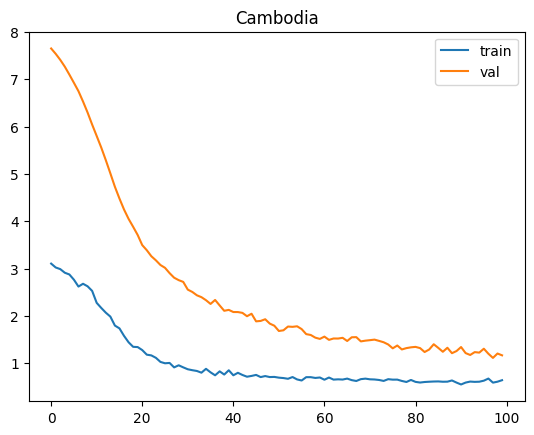

Indonesia
Epoch 0: train loss 1.1980, val loss 1.6895, time 0.0191
Epoch 1: train loss 1.1818, val loss 1.6692, time 0.0155
Epoch 2: train loss 1.1778, val loss 1.6498, time 0.0154
Epoch 3: train loss 1.1585, val loss 1.6302, time 0.0154
Epoch 4: train loss 1.1299, val loss 1.6075, time 0.0155
Epoch 5: train loss 1.1313, val loss 1.5906, time 0.0155
Epoch 6: train loss 1.1428, val loss 1.5714, time 0.0154
Epoch 7: train loss 1.1416, val loss 1.5502, time 0.0157
Epoch 8: train loss 1.0995, val loss 1.5321, time 0.0153
Epoch 9: train loss 1.0945, val loss 1.5112, time 0.0164
Epoch 10: train loss 1.1014, val loss 1.4926, time 0.0155
Epoch 11: train loss 1.0896, val loss 1.4734, time 0.0154
Epoch 12: train loss 1.0947, val loss 1.4498, time 0.0151
Epoch 13: train loss 1.0267, val loss 1.4268, time 0.0152
Epoch 14: train loss 1.0632, val loss 1.4050, time 0.0153
Epoch 15: train loss 1.0972, val loss 1.3933, time 0.0152
Epoch 16: train loss 1.0979, val loss 1.3738, time 0.0152
Epoch 17: trai

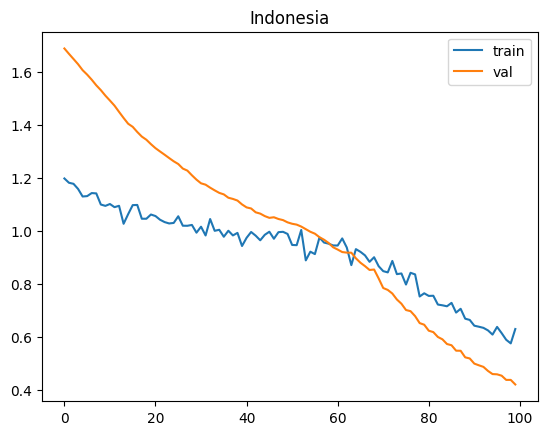

Singapore
Epoch 0: train loss 1.1586, val loss 3.4572, time 0.0706
Epoch 1: train loss 1.1244, val loss 3.4142, time 0.0640
Epoch 2: train loss 1.1493, val loss 3.3633, time 0.0628
Epoch 3: train loss 1.1538, val loss 3.3069, time 0.0630
Epoch 4: train loss 1.1000, val loss 3.2450, time 0.0635
Epoch 5: train loss 1.0557, val loss 3.1801, time 0.0614
Epoch 6: train loss 1.0631, val loss 3.1003, time 0.0605
Epoch 7: train loss 1.0191, val loss 3.0197, time 0.0612
Epoch 8: train loss 1.0001, val loss 2.9268, time 0.0614
Epoch 9: train loss 0.9514, val loss 2.8308, time 0.0635
Epoch 10: train loss 0.9367, val loss 2.7174, time 0.0624
Epoch 11: train loss 0.8928, val loss 2.5900, time 0.0622
Epoch 12: train loss 0.8615, val loss 2.4485, time 0.0633
Epoch 13: train loss 0.8220, val loss 2.3060, time 0.0623
Epoch 14: train loss 0.7705, val loss 2.1492, time 0.0624
Epoch 15: train loss 0.7380, val loss 1.9996, time 0.0624
Epoch 16: train loss 0.7015, val loss 1.8499, time 0.0633
Epoch 17: trai

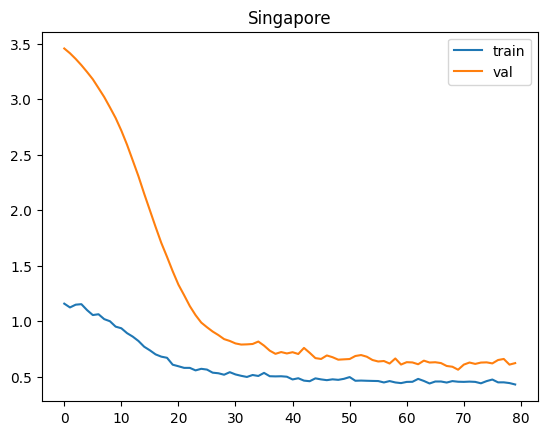

New Zealand
Epoch 0: train loss 1.8098, val loss 3.8481, time 0.0700
Epoch 1: train loss 1.7705, val loss 3.7683, time 0.0616
Epoch 2: train loss 1.7355, val loss 3.6701, time 0.0613
Epoch 3: train loss 1.7219, val loss 3.5552, time 0.0628
Epoch 4: train loss 1.6086, val loss 3.4356, time 0.0633
Epoch 5: train loss 1.5941, val loss 3.2909, time 0.0623
Epoch 6: train loss 1.5671, val loss 3.1219, time 0.0627
Epoch 7: train loss 1.4711, val loss 2.9381, time 0.0637
Epoch 8: train loss 1.4211, val loss 2.7290, time 0.0638
Epoch 9: train loss 1.3393, val loss 2.5150, time 0.0629
Epoch 10: train loss 1.2598, val loss 2.2947, time 0.0627
Epoch 11: train loss 1.2019, val loss 2.0796, time 0.0644
Epoch 12: train loss 1.0993, val loss 1.8534, time 0.0638
Epoch 13: train loss 1.0203, val loss 1.6585, time 0.0635
Epoch 14: train loss 0.9713, val loss 1.4777, time 0.0630
Epoch 15: train loss 0.9378, val loss 1.3245, time 0.0629
Epoch 16: train loss 0.9092, val loss 1.2047, time 0.0637
Epoch 17: tr

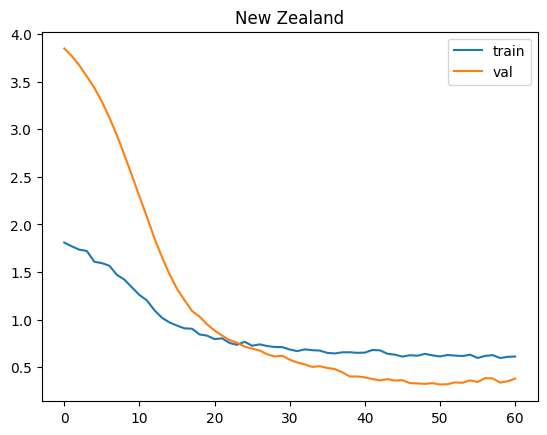

USA
Epoch 0: train loss 3.3549, val loss 6.0321, time 0.0830
Epoch 1: train loss 3.4928, val loss 5.9625, time 0.0720
Epoch 2: train loss 3.5437, val loss 5.8752, time 0.0719
Epoch 3: train loss 3.6178, val loss 5.8092, time 0.0729
Epoch 4: train loss 3.7052, val loss 5.7370, time 0.0720
Epoch 5: train loss 3.3448, val loss 5.5950, time 0.0710
Epoch 6: train loss 3.8280, val loss 5.4276, time 0.0739
Epoch 7: train loss 3.3904, val loss 5.2631, time 0.0721
Epoch 8: train loss 3.9674, val loss 5.0559, time 0.0726
Epoch 9: train loss 3.7488, val loss 4.8117, time 0.0725
Epoch 10: train loss 3.5712, val loss 4.5641, time 0.0714
Epoch 11: train loss 2.5061, val loss 4.3669, time 0.0714
Epoch 12: train loss 2.9973, val loss 4.0940, time 0.0719
Epoch 13: train loss 2.8422, val loss 3.7954, time 0.0725
Epoch 14: train loss 2.3875, val loss 3.4774, time 0.0722
Epoch 15: train loss 2.2212, val loss 3.1980, time 0.0729
Epoch 16: train loss 2.1003, val loss 2.9671, time 0.0716
Epoch 17: train loss

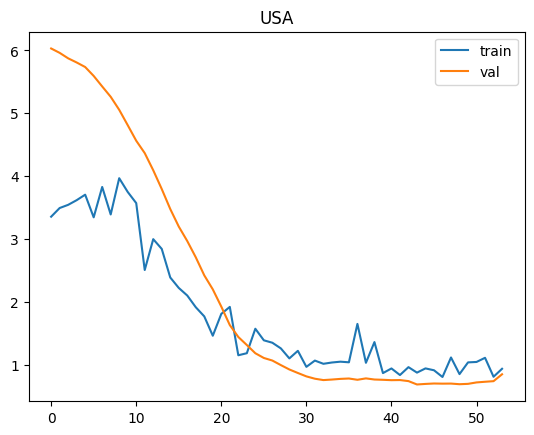

Thailand
Epoch 0: train loss 2.4881, val loss 5.8020, time 0.1047
Epoch 1: train loss 2.4495, val loss 5.7188, time 0.0909
Epoch 2: train loss 2.3678, val loss 5.6285, time 0.0913
Epoch 3: train loss 2.3093, val loss 5.5232, time 0.0923
Epoch 4: train loss 2.2546, val loss 5.3981, time 0.0896
Epoch 5: train loss 2.1579, val loss 5.2522, time 0.0895
Epoch 6: train loss 2.0984, val loss 5.0773, time 0.0913
Epoch 7: train loss 1.9872, val loss 4.8774, time 0.0915
Epoch 8: train loss 1.9243, val loss 4.6340, time 0.0913
Epoch 9: train loss 1.8518, val loss 4.3639, time 0.0917
Epoch 10: train loss 1.7536, val loss 4.0616, time 0.0900
Epoch 11: train loss 1.6498, val loss 3.7228, time 0.0893
Epoch 12: train loss 1.5452, val loss 3.3695, time 0.0921
Epoch 13: train loss 1.4318, val loss 3.0098, time 0.0902
Epoch 14: train loss 1.3532, val loss 2.6964, time 0.0892
Epoch 15: train loss 1.2528, val loss 2.3970, time 0.0894
Epoch 16: train loss 1.2112, val loss 2.1882, time 0.0892
Epoch 17: train

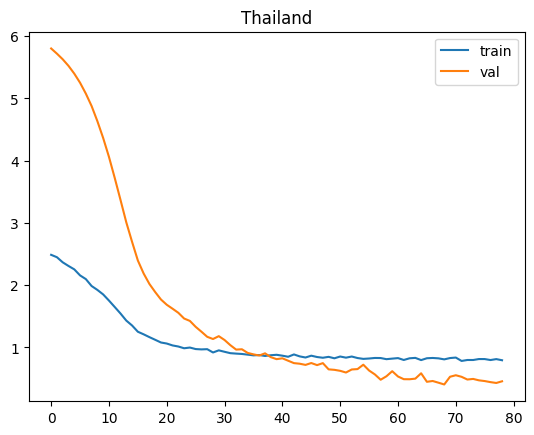

Turkey
Epoch 0: train loss 2.2823, val loss 6.0031, time 0.0842
Epoch 1: train loss 2.0357, val loss 5.8822, time 0.0741
Epoch 2: train loss 1.9996, val loss 5.7511, time 0.0737
Epoch 3: train loss 1.8929, val loss 5.6067, time 0.0745
Epoch 4: train loss 1.9533, val loss 5.4431, time 0.0740
Epoch 5: train loss 2.1187, val loss 5.2463, time 0.0739
Epoch 6: train loss 1.7070, val loss 5.0515, time 0.0754
Epoch 7: train loss 1.7230, val loss 4.8086, time 0.0747
Epoch 8: train loss 1.6123, val loss 4.5397, time 0.0739
Epoch 9: train loss 1.5243, val loss 4.2543, time 0.0756
Epoch 10: train loss 1.3395, val loss 4.0068, time 0.0743
Epoch 11: train loss 1.2019, val loss 3.7432, time 0.0737
Epoch 12: train loss 1.2333, val loss 3.4842, time 0.0747
Epoch 13: train loss 1.0866, val loss 3.2752, time 0.0743
Epoch 14: train loss 0.9765, val loss 3.1144, time 0.0735
Epoch 15: train loss 1.0448, val loss 2.9716, time 0.0751
Epoch 16: train loss 0.9629, val loss 2.8807, time 0.0740
Epoch 17: train l

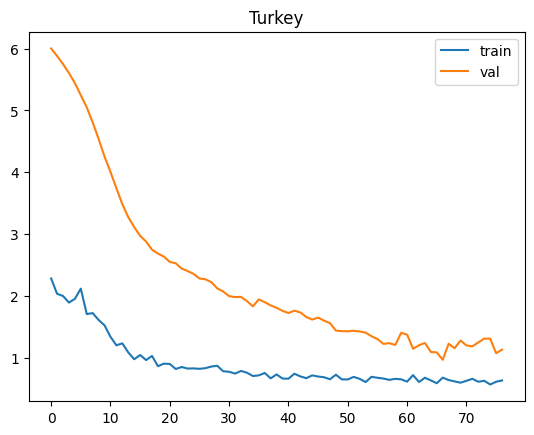

Australia
Epoch 0: train loss 3.7954, val loss 8.7099, time 0.1354
Epoch 1: train loss 3.6820, val loss 8.3799, time 0.1182
Epoch 2: train loss 3.4302, val loss 7.9719, time 0.1174
Epoch 3: train loss 3.4149, val loss 7.4215, time 0.1169
Epoch 4: train loss 3.0024, val loss 6.8366, time 0.1165
Epoch 5: train loss 2.7945, val loss 6.1212, time 0.1166
Epoch 6: train loss 2.5442, val loss 5.3501, time 0.1179
Epoch 7: train loss 2.1496, val loss 4.5546, time 0.1155
Epoch 8: train loss 1.9261, val loss 3.8408, time 0.1163
Epoch 9: train loss 1.7004, val loss 3.2896, time 0.1154
Epoch 10: train loss 1.6564, val loss 2.8357, time 0.1198
Epoch 11: train loss 1.4653, val loss 2.4339, time 0.1169
Epoch 12: train loss 1.3350, val loss 2.2066, time 0.1182
Epoch 13: train loss 1.2205, val loss 1.8360, time 0.1157
Epoch 14: train loss 1.1811, val loss 1.5507, time 0.1185
Epoch 15: train loss 1.1779, val loss 1.3605, time 0.1170
Epoch 16: train loss 1.1132, val loss 1.4117, time 0.1171
Epoch 17: trai

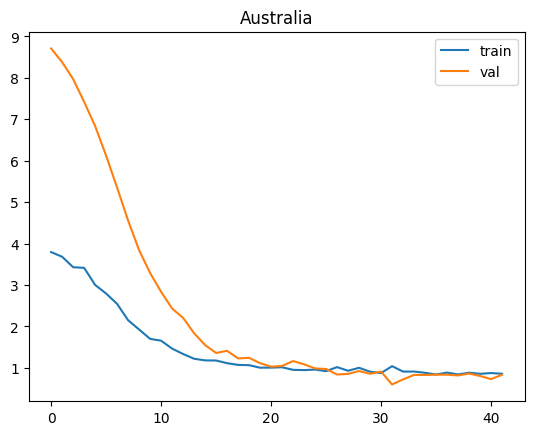

Hawaii
Epoch 0: train loss 2.3473, val loss 2.6108, time 0.0902
Epoch 1: train loss 2.2951, val loss 2.5215, time 0.0792
Epoch 2: train loss 2.2193, val loss 2.4350, time 0.0776
Epoch 3: train loss 2.2397, val loss 2.3301, time 0.0782
Epoch 4: train loss 2.1618, val loss 2.2054, time 0.0791
Epoch 5: train loss 2.0956, val loss 2.0577, time 0.0788
Epoch 6: train loss 2.0949, val loss 1.8926, time 0.0793
Epoch 7: train loss 1.9724, val loss 1.7433, time 0.0785
Epoch 8: train loss 1.8474, val loss 1.5818, time 0.0780
Epoch 9: train loss 1.7997, val loss 1.4357, time 0.0784
Epoch 10: train loss 1.6422, val loss 1.2975, time 0.0798
Epoch 11: train loss 1.5302, val loss 1.1454, time 0.0788
Epoch 12: train loss 1.4027, val loss 1.0328, time 0.0794
Epoch 13: train loss 1.3315, val loss 0.9415, time 0.0795
Epoch 14: train loss 1.2328, val loss 0.9022, time 0.0783
Epoch 15: train loss 1.1621, val loss 0.9143, time 0.0791
Epoch 16: train loss 1.1174, val loss 1.0026, time 0.0792
Epoch 17: train l

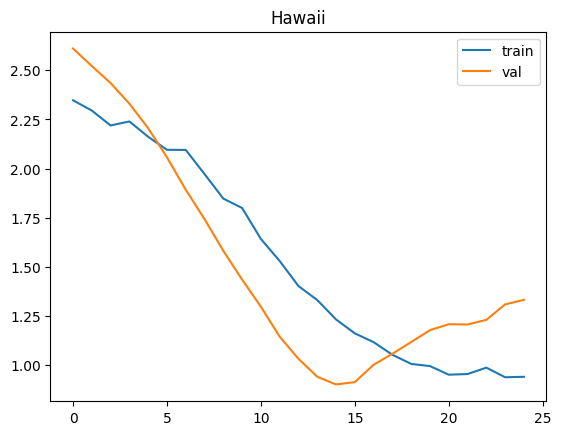

Austria
Epoch 0: train loss 2.6583, val loss 5.9794, time 0.0654
Epoch 1: train loss 2.5658, val loss 5.9049, time 0.0564
Epoch 2: train loss 2.4970, val loss 5.8252, time 0.0561
Epoch 3: train loss 2.5467, val loss 5.7339, time 0.0559
Epoch 4: train loss 2.4475, val loss 5.6422, time 0.0569
Epoch 5: train loss 2.3724, val loss 5.5454, time 0.0561
Epoch 6: train loss 2.4068, val loss 5.4233, time 0.0563
Epoch 7: train loss 2.3019, val loss 5.3047, time 0.0567
Epoch 8: train loss 2.2002, val loss 5.1663, time 0.0575
Epoch 9: train loss 2.1874, val loss 5.0007, time 0.0570
Epoch 10: train loss 2.0840, val loss 4.8196, time 0.0564
Epoch 11: train loss 2.0249, val loss 4.6093, time 0.0558
Epoch 12: train loss 1.8611, val loss 4.3800, time 0.0571
Epoch 13: train loss 1.8092, val loss 4.1148, time 0.0565
Epoch 14: train loss 1.6360, val loss 3.8361, time 0.0564
Epoch 15: train loss 1.5375, val loss 3.5640, time 0.0551
Epoch 16: train loss 1.4194, val loss 3.2804, time 0.0562
Epoch 17: train 

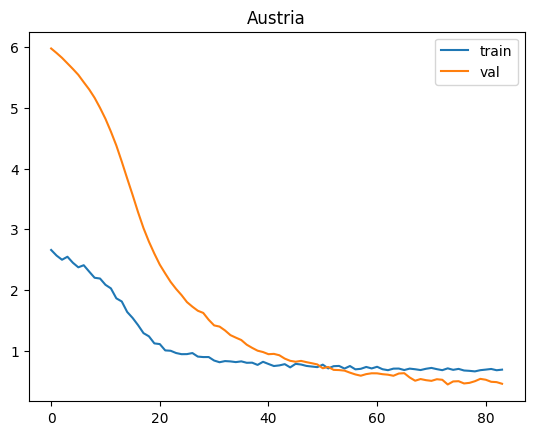

Czech
Epoch 0: train loss 1.7674, val loss 3.6295, time 0.0219
Epoch 1: train loss 1.7250, val loss 3.6065, time 0.0188
Epoch 2: train loss 1.7305, val loss 3.5829, time 0.0192
Epoch 3: train loss 1.7182, val loss 3.5607, time 0.0192
Epoch 4: train loss 1.7240, val loss 3.5364, time 0.0187
Epoch 5: train loss 1.6890, val loss 3.5129, time 0.0190
Epoch 6: train loss 1.6930, val loss 3.4863, time 0.0196
Epoch 7: train loss 1.6904, val loss 3.4595, time 0.0192
Epoch 8: train loss 1.6408, val loss 3.4351, time 0.0190
Epoch 9: train loss 1.6113, val loss 3.4119, time 0.0188
Epoch 10: train loss 1.6431, val loss 3.3838, time 0.0190
Epoch 11: train loss 1.5819, val loss 3.3572, time 0.0189
Epoch 12: train loss 1.5809, val loss 3.3301, time 0.0189
Epoch 13: train loss 1.5922, val loss 3.3041, time 0.0189
Epoch 14: train loss 1.5791, val loss 3.2753, time 0.0190
Epoch 15: train loss 1.5906, val loss 3.2471, time 0.0188
Epoch 16: train loss 1.5316, val loss 3.2183, time 0.0188
Epoch 17: train lo

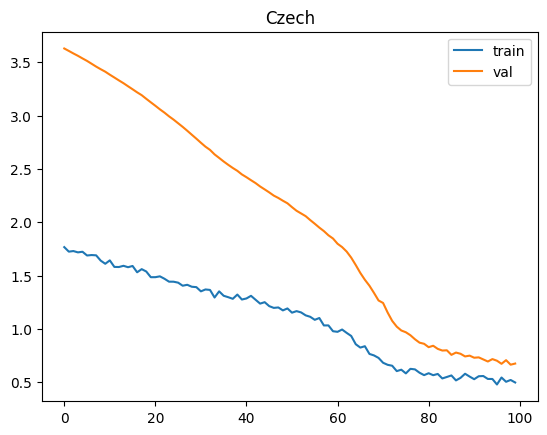

In [64]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=15, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [65]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 301901.57767
RNN Sep R2: 0.89475
RNN Sep MAE: 98764.29282
RNN Sep MAPE: 0.18198
RNN Sep MASE: 2.06255


### Ensemble RNN models

In [66]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.5
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 313510.20339
Weight: 0.1, RMSE: 307005.96506
Weight: 0.2, RMSE: 301587.14439
Weight: 0.3, RMSE: 297313.09567
Weight: 0.4, RMSE: 294233.71012
Weight: 0.5, RMSE: 292386.73638
Weight: 0.6, RMSE: 291795.57770
Weight: 0.7, RMSE: 292467.84925
Weight: 0.8, RMSE: 294394.89575
Weight: 0.9, RMSE: 297552.33920


In [67]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 292386.73638
RNN Ensemble R2: 0.90128
RNN Ensemble MAE: 84835.45187
RNN Ensemble MAPE: 0.18473
RNN Ensemble MASE: 1.97643


# Ordinal Temporal Features
### RNN

In [46]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [47]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

Epoch 0: train loss 1.8987, val loss 1.3605, time 1.6327
Epoch 1: train loss 1.0186, val loss 0.9823, time 1.4341
Epoch 2: train loss 0.8531, val loss 0.9267, time 1.4402
Epoch 3: train loss 0.8142, val loss 0.8877, time 1.4451
Epoch 4: train loss 0.7896, val loss 0.8822, time 1.4552
Epoch 5: train loss 0.7620, val loss 0.8707, time 1.4628
Epoch 6: train loss 0.7571, val loss 0.8609, time 1.4479
Epoch 7: train loss 0.7478, val loss 0.9202, time 1.3989
Epoch 8: train loss 0.7428, val loss 0.8429, time 1.4089
Epoch 9: train loss 0.7218, val loss 0.8359, time 1.3989
Epoch 10: train loss 0.7195, val loss 0.8425, time 1.4012
Epoch 11: train loss 0.7202, val loss 0.8289, time 1.4000
Epoch 12: train loss 0.7217, val loss 0.8158, time 1.4058
Epoch 13: train loss 0.7022, val loss 0.8042, time 1.4013
Epoch 14: train loss 0.7017, val loss 1.0863, time 1.4013
Epoch 15: train loss 0.7059, val loss 0.8137, time 1.4263
Epoch 16: train loss 0.7023, val loss 0.8030, time 1.4241
Epoch 17: train loss 0.6

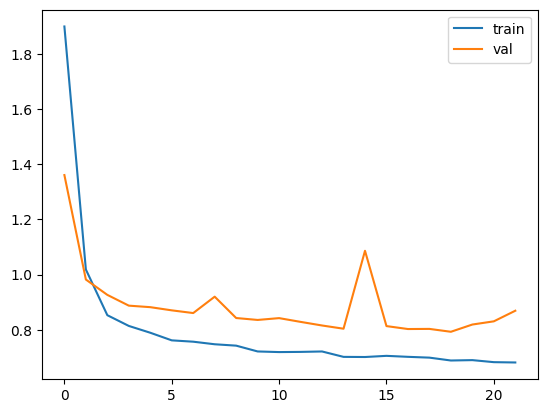

In [48]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=18, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [49]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [50]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [51]:
(all_y == rnn_gt).all()

True

In [52]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 427867.85023
RNN R2: 0.78860
RNN MAE: 115182.09997
RNN MAPE: 0.25727
RNN MASE: 2.53401


## One Step RNN

In [65]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest','Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 1.3829, val loss 0.8542, time 1.8861
Epoch 1: train loss 0.8625, val loss 0.8618, time 1.6511
Epoch 2: train loss 0.7266, val loss 0.6652, time 1.6506
Epoch 3: train loss 0.5770, val loss 0.5224, time 1.6343
Epoch 4: train loss 0.5450, val loss 0.5279, time 1.6324
Epoch 5: train loss 0.5377, val loss 0.5193, time 1.6293
Epoch 6: train loss 0.5220, val loss 0.4980, time 1.6253
Epoch 7: train loss 0.5164, val loss 0.4848, time 1.6346
Epoch 8: train loss 0.5069, val loss 0.5379, time 1.6293
Epoch 9: train loss 0.5355, val loss 0.5389, time 1.6364
Epoch 10: train loss 0.5214, val loss 0.4808, time 1.6320
Epoch 11: train loss 0.5113, val loss 0.4866, time 1.6270
Epoch 12: train loss 0.5212, val loss 0.7970, time 1.6256
Epoch 13: train loss 0.5411, val loss 0.5030, time 1.6918
Early stopping as no improvement in val loss


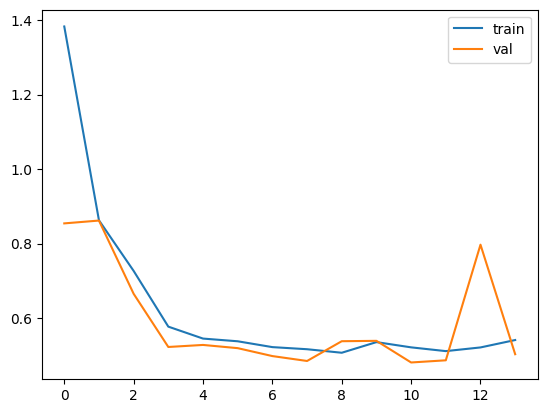

In [66]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=18, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [67]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [68]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [69]:
(rnn_gt == all_y).all()

True

In [70]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 302474.55317
RNN R2: 0.89435
RNN MAE: 90026.57540
RNN MAPE: 0.21364
RNN MASE: 2.16298


### Separate RNN models

In [74]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 3.0101, val loss 5.9435, time 0.0825
Epoch 1: train loss 3.0005, val loss 5.8961, time 0.0720
Epoch 2: train loss 2.9517, val loss 5.8473, time 0.0720
Epoch 3: train loss 2.9100, val loss 5.7938, time 0.0728
Epoch 4: train loss 2.8594, val loss 5.7355, time 0.0708
Epoch 5: train loss 2.8264, val loss 5.6684, time 0.0719
Epoch 6: train loss 2.7175, val loss 5.5924, time 0.0733
Epoch 7: train loss 2.6842, val loss 5.5020, time 0.0726
Epoch 8: train loss 2.6073, val loss 5.3908, time 0.0717
Epoch 9: train loss 2.5316, val loss 5.2691, time 0.0721
Epoch 10: train loss 2.4736, val loss 5.0903, time 0.0718
Epoch 11: train loss 2.3822, val loss 4.9220, time 0.0717
Epoch 12: train loss 2.2767, val loss 4.7273, time 0.0735
Epoch 13: train loss 2.1474, val loss 4.4479, time 0.0717
Epoch 14: train loss 2.0987, val loss 4.1474, time 0.0700
Epoch 15: train loss 1.9006, val loss 3.8909, time 0.0710
Epoch 16: train loss 1.7490, val loss 3.6199, time 0.0702
Epoch 17: train l

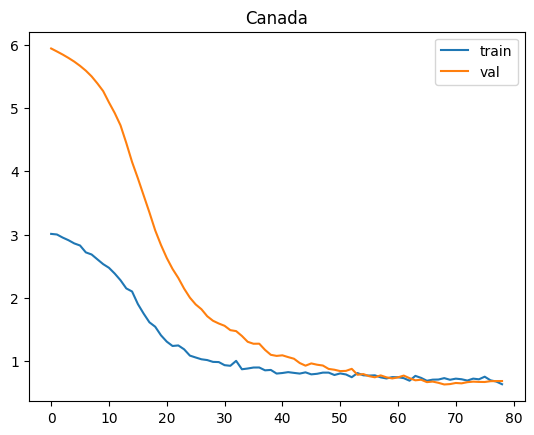

Chile
Epoch 0: train loss 2.2871, val loss 3.1607, time 0.0260
Epoch 1: train loss 2.2955, val loss 3.1503, time 0.0218
Epoch 2: train loss 2.2721, val loss 3.1378, time 0.0216
Epoch 3: train loss 2.2785, val loss 3.1308, time 0.0227
Epoch 4: train loss 2.2816, val loss 3.1131, time 0.0220
Epoch 5: train loss 2.2676, val loss 3.1131, time 0.0221
Epoch 6: train loss 2.2679, val loss 3.1082, time 0.0224
Epoch 7: train loss 2.2185, val loss 3.0960, time 0.0220
Epoch 8: train loss 2.2166, val loss 3.0869, time 0.0217
Epoch 9: train loss 2.2640, val loss 3.0742, time 0.0217
Epoch 10: train loss 2.2133, val loss 3.0644, time 0.0220
Epoch 11: train loss 2.2091, val loss 3.0560, time 0.0219
Epoch 12: train loss 2.1777, val loss 3.0507, time 0.0218
Epoch 13: train loss 2.1964, val loss 3.0421, time 0.0217
Epoch 14: train loss 2.2163, val loss 3.0321, time 0.0218
Epoch 15: train loss 2.2302, val loss 3.0260, time 0.0224
Epoch 16: train loss 2.1628, val loss 3.0144, time 0.0219
Epoch 17: train lo

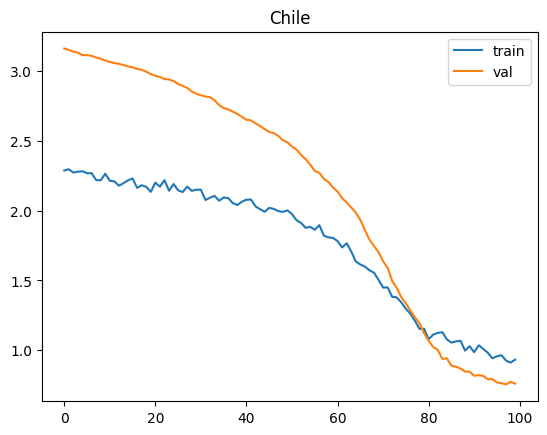

Mexico
Epoch 0: train loss 2.3005, val loss 4.6985, time 0.0663
Epoch 1: train loss 2.2277, val loss 4.7156, time 0.0591
Epoch 2: train loss 2.1653, val loss 4.7088, time 0.0583
Epoch 3: train loss 2.0369, val loss 4.6701, time 0.0585
Epoch 4: train loss 2.1076, val loss 4.6283, time 0.0578
Epoch 5: train loss 1.9475, val loss 4.5522, time 0.0580
Epoch 6: train loss 2.0352, val loss 4.5025, time 0.0571
Epoch 7: train loss 1.8356, val loss 4.4443, time 0.0569
Epoch 8: train loss 2.2642, val loss 4.3799, time 0.0588
Epoch 9: train loss 2.0253, val loss 4.3151, time 0.0590
Epoch 10: train loss 1.8368, val loss 4.1990, time 0.0592
Epoch 11: train loss 1.8727, val loss 4.0457, time 0.0587
Epoch 12: train loss 1.8188, val loss 3.9216, time 0.0592
Epoch 13: train loss 1.7941, val loss 3.8523, time 0.0577
Epoch 14: train loss 1.5782, val loss 3.7870, time 0.0578
Epoch 15: train loss 1.7335, val loss 3.6321, time 0.0577
Epoch 16: train loss 1.5291, val loss 3.4282, time 0.0582
Epoch 17: train l

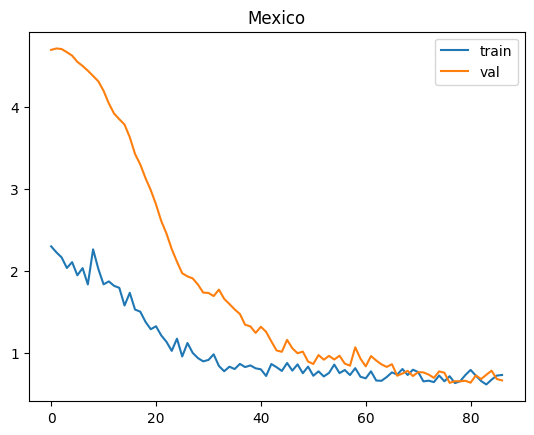

Chinese Taipei
Epoch 0: train loss 0.9778, val loss 1.5723, time 0.0455
Epoch 1: train loss 0.9202, val loss 1.5338, time 0.0399
Epoch 2: train loss 0.9818, val loss 1.5069, time 0.0396
Epoch 3: train loss 0.9041, val loss 1.4706, time 0.0396
Epoch 4: train loss 0.8531, val loss 1.4437, time 0.0396
Epoch 5: train loss 0.8607, val loss 1.4111, time 0.0391
Epoch 6: train loss 0.8348, val loss 1.3782, time 0.0406
Epoch 7: train loss 0.8395, val loss 1.3433, time 0.0406
Epoch 8: train loss 0.8077, val loss 1.3060, time 0.0405
Epoch 9: train loss 0.7588, val loss 1.2802, time 0.0403
Epoch 10: train loss 0.7501, val loss 1.2509, time 0.0404
Epoch 11: train loss 0.7445, val loss 1.2134, time 0.0401
Epoch 12: train loss 0.7231, val loss 1.1864, time 0.0400
Epoch 13: train loss 0.7038, val loss 1.1684, time 0.0404
Epoch 14: train loss 0.6734, val loss 1.1526, time 0.0402
Epoch 15: train loss 0.6975, val loss 1.1466, time 0.0400
Epoch 16: train loss 0.6626, val loss 1.1333, time 0.0400
Epoch 17:

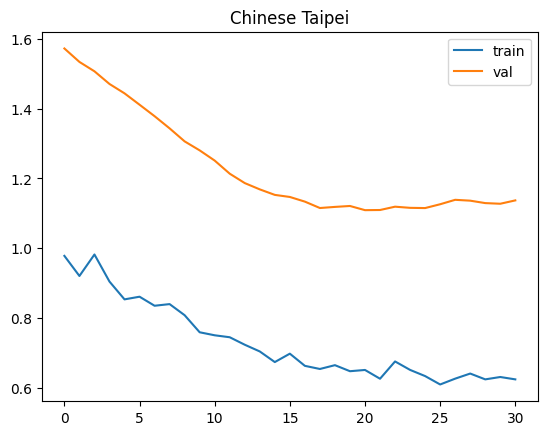

Hong Kong SAR
Epoch 0: train loss 3.1337, val loss 5.2207, time 0.1001
Epoch 1: train loss 3.1265, val loss 4.8962, time 0.0897
Epoch 2: train loss 3.0844, val loss 4.5937, time 0.0877
Epoch 3: train loss 2.9105, val loss 4.2729, time 0.0884
Epoch 4: train loss 2.9099, val loss 3.9269, time 0.0860
Epoch 5: train loss 2.8254, val loss 3.6220, time 0.0858
Epoch 6: train loss 2.4743, val loss 3.4146, time 0.0881
Epoch 7: train loss 2.5003, val loss 3.1628, time 0.0883
Epoch 8: train loss 2.3419, val loss 3.0024, time 0.0876
Epoch 9: train loss 2.2220, val loss 2.8830, time 0.0868
Epoch 10: train loss 2.0212, val loss 2.7727, time 0.0867
Epoch 11: train loss 1.8540, val loss 2.6927, time 0.0863
Epoch 12: train loss 1.7479, val loss 2.6316, time 0.0891
Epoch 13: train loss 1.5446, val loss 2.5522, time 0.0874
Epoch 14: train loss 1.4044, val loss 2.4218, time 0.0865
Epoch 15: train loss 1.2952, val loss 2.3456, time 0.0872
Epoch 16: train loss 1.2481, val loss 2.2528, time 0.0873
Epoch 17: 

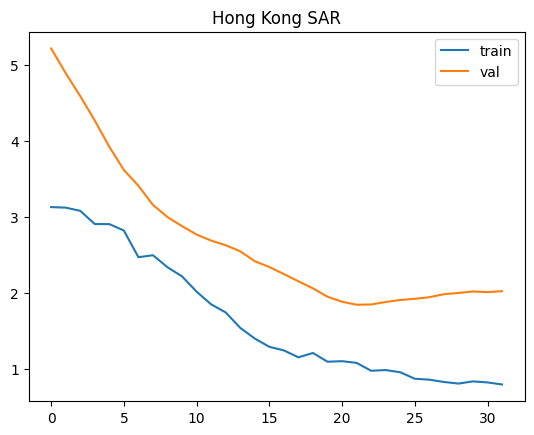

Japan
Epoch 0: train loss 5.3062, val loss 8.3127, time 0.1097
Epoch 1: train loss 5.0475, val loss 8.3183, time 0.0948
Epoch 2: train loss 5.0356, val loss 8.3112, time 0.0940
Epoch 3: train loss 4.7675, val loss 8.2901, time 0.0965
Epoch 4: train loss 4.6518, val loss 8.2738, time 0.0970
Epoch 5: train loss 4.3169, val loss 8.2101, time 0.0958
Epoch 6: train loss 4.1302, val loss 8.1284, time 0.0961
Epoch 7: train loss 4.0693, val loss 8.0306, time 0.0941
Epoch 8: train loss 3.9157, val loss 7.9338, time 0.0943
Epoch 9: train loss 3.7217, val loss 7.7862, time 0.0994
Epoch 10: train loss 3.5488, val loss 7.6077, time 0.0967
Epoch 11: train loss 3.2853, val loss 7.3935, time 0.0950
Epoch 12: train loss 3.1748, val loss 7.1269, time 0.0959
Epoch 13: train loss 3.0190, val loss 6.8060, time 0.0950
Epoch 14: train loss 2.7577, val loss 6.5100, time 0.0968
Epoch 15: train loss 2.6027, val loss 6.2011, time 0.0972
Epoch 16: train loss 2.5959, val loss 5.8709, time 0.0960
Epoch 17: train lo

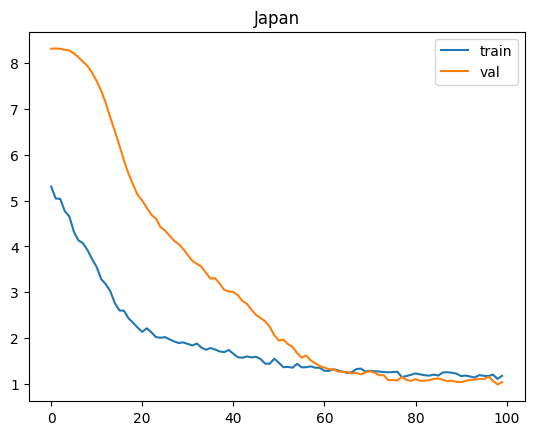

Korea (ROK)
Epoch 0: train loss 3.3716, val loss 5.1903, time 0.1056
Epoch 1: train loss 3.3089, val loss 5.0932, time 0.0904
Epoch 2: train loss 3.2022, val loss 4.9677, time 0.0904
Epoch 3: train loss 3.0647, val loss 4.8221, time 0.0927
Epoch 4: train loss 2.9925, val loss 4.6674, time 0.0927
Epoch 5: train loss 2.9151, val loss 4.4848, time 0.0922
Epoch 6: train loss 2.7905, val loss 4.2735, time 0.0919
Epoch 7: train loss 2.6953, val loss 4.0250, time 0.0903
Epoch 8: train loss 2.5656, val loss 3.7681, time 0.0909
Epoch 9: train loss 2.3599, val loss 3.4494, time 0.0942
Epoch 10: train loss 2.2265, val loss 3.0947, time 0.0913
Epoch 11: train loss 1.9701, val loss 2.6986, time 0.0918
Epoch 12: train loss 1.7587, val loss 2.2892, time 0.0915
Epoch 13: train loss 1.5837, val loss 1.9401, time 0.0911
Epoch 14: train loss 1.4831, val loss 1.5873, time 0.0927
Epoch 15: train loss 1.3382, val loss 1.4008, time 0.0930
Epoch 16: train loss 1.3102, val loss 1.1792, time 0.0912
Epoch 17: tr

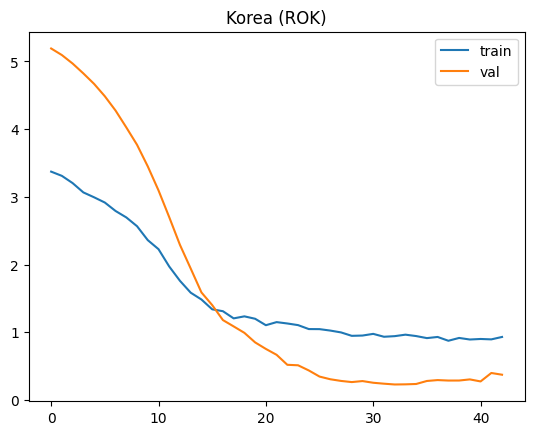

Macao, China
Epoch 0: train loss 2.1036, val loss 4.8236, time 0.1011
Epoch 1: train loss 1.8351, val loss 4.5887, time 0.0879
Epoch 2: train loss 1.8525, val loss 4.3110, time 0.0879
Epoch 3: train loss 1.7513, val loss 4.1249, time 0.0875
Epoch 4: train loss 1.6766, val loss 3.8895, time 0.0869
Epoch 5: train loss 1.6028, val loss 3.6339, time 0.0887
Epoch 6: train loss 1.5714, val loss 3.3855, time 0.0890
Epoch 7: train loss 1.5362, val loss 3.0965, time 0.0885
Epoch 8: train loss 1.4314, val loss 2.8351, time 0.0874
Epoch 9: train loss 1.3189, val loss 2.6440, time 0.0876
Epoch 10: train loss 1.2861, val loss 2.4416, time 0.0879
Epoch 11: train loss 1.3295, val loss 2.3041, time 0.0882
Epoch 12: train loss 1.2124, val loss 2.1912, time 0.0886
Epoch 13: train loss 1.0899, val loss 1.8883, time 0.0874
Epoch 14: train loss 1.0141, val loss 1.6835, time 0.0873
Epoch 15: train loss 0.9933, val loss 1.4119, time 0.0876
Epoch 16: train loss 0.8614, val loss 1.3696, time 0.0881
Epoch 17: t

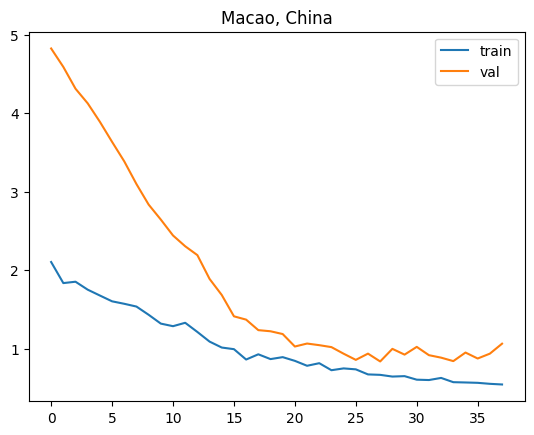

Maldives
Epoch 0: train loss 2.4793, val loss 2.9704, time 0.1030
Epoch 1: train loss 2.5806, val loss 2.8853, time 0.0913
Epoch 2: train loss 2.4404, val loss 2.7482, time 0.0938
Epoch 3: train loss 2.4082, val loss 2.6063, time 0.0922
Epoch 4: train loss 2.2637, val loss 2.4144, time 0.0902
Epoch 5: train loss 2.2048, val loss 2.2283, time 0.0904
Epoch 6: train loss 2.1018, val loss 2.0176, time 0.0916
Epoch 7: train loss 2.0215, val loss 1.7864, time 0.0931
Epoch 8: train loss 1.9069, val loss 1.5428, time 0.0934
Epoch 9: train loss 1.7527, val loss 1.3101, time 0.0928
Epoch 10: train loss 1.6356, val loss 1.1198, time 0.0905
Epoch 11: train loss 1.5056, val loss 0.9366, time 0.1019
Epoch 12: train loss 1.3614, val loss 0.7458, time 0.0928
Epoch 13: train loss 1.1917, val loss 0.6224, time 0.0929
Epoch 14: train loss 1.1773, val loss 0.6628, time 0.0912
Epoch 15: train loss 1.0594, val loss 0.6701, time 0.0914
Epoch 16: train loss 0.9781, val loss 0.7046, time 0.0907
Epoch 17: train

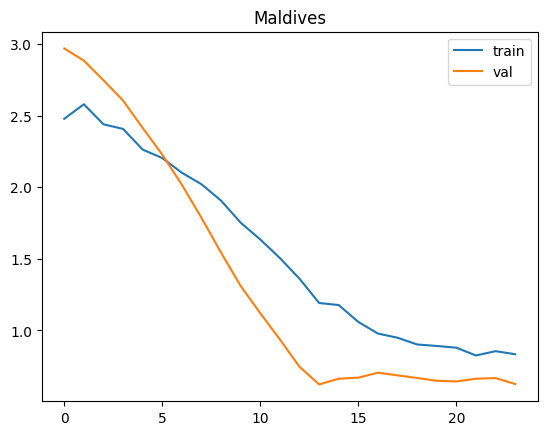

Cambodia
Epoch 0: train loss 3.0736, val loss 7.5159, time 0.0763
Epoch 1: train loss 2.9249, val loss 7.4386, time 0.0672
Epoch 2: train loss 2.8062, val loss 7.3384, time 0.0677
Epoch 3: train loss 2.8303, val loss 7.2340, time 0.0695
Epoch 4: train loss 2.7263, val loss 7.1036, time 0.0676
Epoch 5: train loss 2.7194, val loss 6.9521, time 0.0671
Epoch 6: train loss 2.5463, val loss 6.7797, time 0.0669
Epoch 7: train loss 2.4961, val loss 6.5902, time 0.0670
Epoch 8: train loss 2.3503, val loss 6.3935, time 0.0676
Epoch 9: train loss 2.2419, val loss 6.1210, time 0.0673
Epoch 10: train loss 2.1762, val loss 5.8850, time 0.0678
Epoch 11: train loss 2.1279, val loss 5.6230, time 0.0673
Epoch 12: train loss 1.8555, val loss 5.3637, time 0.0669
Epoch 13: train loss 1.7516, val loss 5.1277, time 0.0673
Epoch 14: train loss 1.6617, val loss 4.8937, time 0.0658
Epoch 15: train loss 1.5816, val loss 4.6812, time 0.0657
Epoch 16: train loss 1.4283, val loss 4.4592, time 0.0685
Epoch 17: train

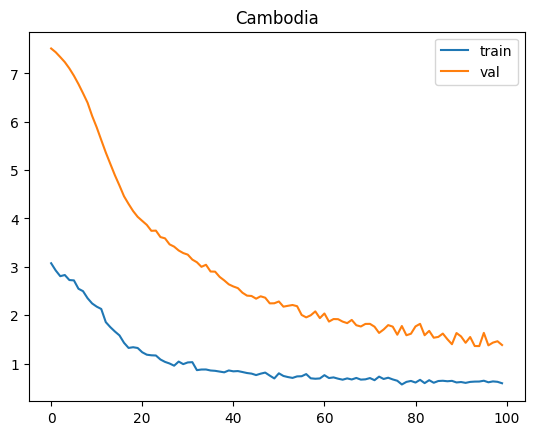

Indonesia
Epoch 0: train loss 1.2148, val loss 1.6351, time 0.0199
Epoch 1: train loss 1.2038, val loss 1.6175, time 0.0173
Epoch 2: train loss 1.2121, val loss 1.6053, time 0.0186
Epoch 3: train loss 1.2065, val loss 1.5865, time 0.0172
Epoch 4: train loss 1.2069, val loss 1.5735, time 0.0172
Epoch 5: train loss 1.1862, val loss 1.5625, time 0.0176
Epoch 6: train loss 1.1666, val loss 1.5479, time 0.0173
Epoch 7: train loss 1.1555, val loss 1.5320, time 0.0172
Epoch 8: train loss 1.1609, val loss 1.5168, time 0.0183
Epoch 9: train loss 1.1373, val loss 1.5032, time 0.0175
Epoch 10: train loss 1.1282, val loss 1.4863, time 0.0172
Epoch 11: train loss 1.1303, val loss 1.4737, time 0.0170
Epoch 12: train loss 1.1381, val loss 1.4574, time 0.0171
Epoch 13: train loss 1.0888, val loss 1.4393, time 0.0181
Epoch 14: train loss 1.0827, val loss 1.4236, time 0.0186
Epoch 15: train loss 1.0862, val loss 1.4078, time 0.0173
Epoch 16: train loss 1.0766, val loss 1.3959, time 0.0177
Epoch 17: trai

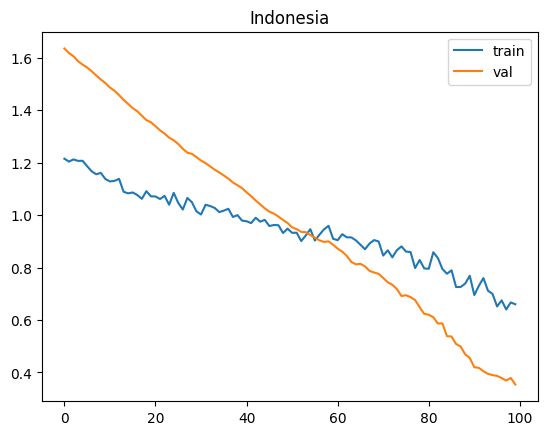

Singapore
Epoch 0: train loss 1.2014, val loss 3.0686, time 0.0814
Epoch 1: train loss 1.1563, val loss 3.0174, time 0.0720
Epoch 2: train loss 1.1485, val loss 2.9546, time 0.0716
Epoch 3: train loss 1.1265, val loss 2.9086, time 0.0728
Epoch 4: train loss 1.1137, val loss 2.8600, time 0.0717
Epoch 5: train loss 1.0968, val loss 2.7836, time 0.0706
Epoch 6: train loss 1.0742, val loss 2.7219, time 0.0716
Epoch 7: train loss 1.0439, val loss 2.6647, time 0.0708
Epoch 8: train loss 1.0173, val loss 2.5990, time 0.0751
Epoch 9: train loss 0.9692, val loss 2.5164, time 0.0741
Epoch 10: train loss 0.9465, val loss 2.4313, time 0.0724
Epoch 11: train loss 0.9072, val loss 2.3318, time 0.0726
Epoch 12: train loss 0.8899, val loss 2.2296, time 0.0733
Epoch 13: train loss 0.8343, val loss 2.1253, time 0.0722
Epoch 14: train loss 0.7878, val loss 1.9915, time 0.0723
Epoch 15: train loss 0.7567, val loss 1.8612, time 0.0741
Epoch 16: train loss 0.7335, val loss 1.7512, time 0.0728
Epoch 17: trai

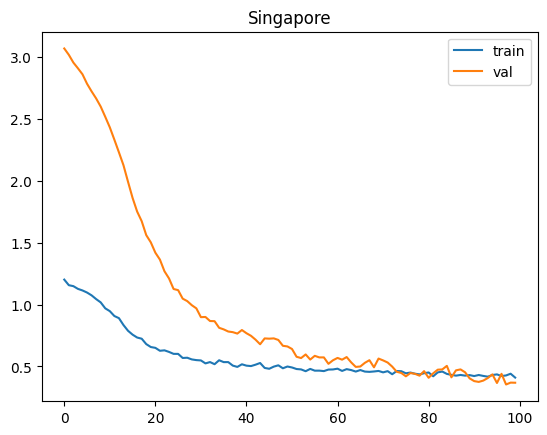

New Zealand
Epoch 0: train loss 1.9312, val loss 4.2682, time 0.0806
Epoch 1: train loss 1.9489, val loss 4.1961, time 0.0720
Epoch 2: train loss 1.9055, val loss 4.1217, time 0.0714
Epoch 3: train loss 1.8609, val loss 4.0556, time 0.0729
Epoch 4: train loss 1.8707, val loss 3.9554, time 0.0713
Epoch 5: train loss 1.7952, val loss 3.8457, time 0.0712
Epoch 6: train loss 1.7885, val loss 3.7216, time 0.0714
Epoch 7: train loss 1.6991, val loss 3.6113, time 0.0704
Epoch 8: train loss 1.6854, val loss 3.4605, time 0.0711
Epoch 9: train loss 1.6026, val loss 3.2969, time 0.0725
Epoch 10: train loss 1.5480, val loss 3.1166, time 0.0711
Epoch 11: train loss 1.4542, val loss 2.9173, time 0.0709
Epoch 12: train loss 1.3771, val loss 2.7140, time 0.0720
Epoch 13: train loss 1.2646, val loss 2.4814, time 0.0706
Epoch 14: train loss 1.2090, val loss 2.2686, time 0.0713
Epoch 15: train loss 1.1145, val loss 2.0167, time 0.0725
Epoch 16: train loss 1.0543, val loss 1.8368, time 0.0710
Epoch 17: tr

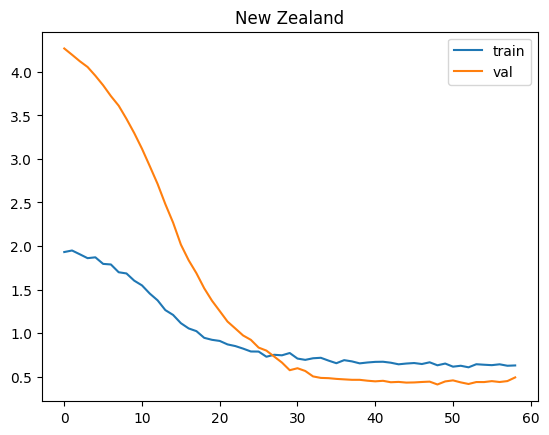

USA
Epoch 0: train loss 4.0882, val loss 5.5165, time 0.0942
Epoch 1: train loss 3.8406, val loss 5.4023, time 0.0827
Epoch 2: train loss 3.5025, val loss 5.1918, time 0.0819
Epoch 3: train loss 3.2375, val loss 4.9699, time 0.0815
Epoch 4: train loss 2.9198, val loss 4.7008, time 0.0809
Epoch 5: train loss 2.8557, val loss 4.5193, time 0.0814
Epoch 6: train loss 2.8231, val loss 4.3099, time 0.0841
Epoch 7: train loss 3.0238, val loss 4.1133, time 0.0824
Epoch 8: train loss 2.3993, val loss 3.8809, time 0.0824
Epoch 9: train loss 2.9846, val loss 3.4726, time 0.0834
Epoch 10: train loss 2.3764, val loss 3.2644, time 0.0822
Epoch 11: train loss 2.5544, val loss 3.0700, time 0.0815
Epoch 12: train loss 2.3771, val loss 2.8426, time 0.0840
Epoch 13: train loss 2.8131, val loss 2.6897, time 0.0822
Epoch 14: train loss 1.7042, val loss 2.5171, time 0.0816
Epoch 15: train loss 1.7617, val loss 2.3452, time 0.0818
Epoch 16: train loss 2.0700, val loss 2.1914, time 0.0816
Epoch 17: train loss

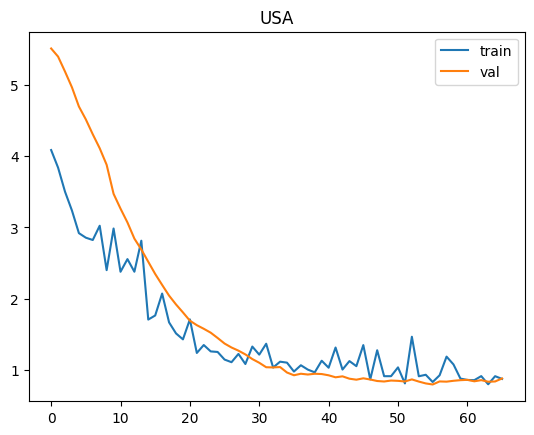

Thailand
Epoch 0: train loss 2.6582, val loss 6.3157, time 0.1190
Epoch 1: train loss 2.6014, val loss 6.3465, time 0.1062
Epoch 2: train loss 2.5419, val loss 6.3619, time 0.1048
Epoch 3: train loss 2.5115, val loss 6.3623, time 0.1031
Epoch 4: train loss 2.4362, val loss 6.3548, time 0.1037
Epoch 5: train loss 2.4035, val loss 6.3305, time 0.1028
Epoch 6: train loss 2.3477, val loss 6.2944, time 0.1077
Epoch 7: train loss 2.2939, val loss 6.1903, time 0.1046
Epoch 8: train loss 2.2508, val loss 6.0471, time 0.1050
Epoch 9: train loss 2.1763, val loss 5.8824, time 0.1043
Epoch 10: train loss 2.0988, val loss 5.6708, time 0.1076
Epoch 11: train loss 2.0176, val loss 5.3974, time 0.1046
Epoch 12: train loss 1.9380, val loss 5.0709, time 0.1036
Epoch 13: train loss 1.8379, val loss 4.7047, time 0.1037
Epoch 14: train loss 1.7360, val loss 4.3285, time 0.1039
Epoch 15: train loss 1.6475, val loss 3.9403, time 0.1050
Epoch 16: train loss 1.5344, val loss 3.5638, time 0.1070
Epoch 17: train

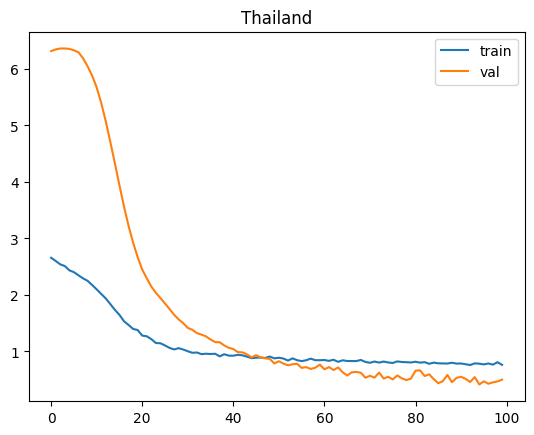

Turkey
Epoch 0: train loss 2.2742, val loss 5.5464, time 0.0961
Epoch 1: train loss 2.1414, val loss 5.3738, time 0.0858
Epoch 2: train loss 1.9934, val loss 5.2238, time 0.0887
Epoch 3: train loss 2.1037, val loss 5.0308, time 0.0864
Epoch 4: train loss 1.9958, val loss 4.8729, time 0.0857
Epoch 5: train loss 1.8663, val loss 4.6911, time 0.0846
Epoch 6: train loss 1.7374, val loss 4.4946, time 0.0855
Epoch 7: train loss 1.6571, val loss 4.2690, time 0.0868
Epoch 8: train loss 1.6550, val loss 4.0557, time 0.0853
Epoch 9: train loss 1.4864, val loss 3.8727, time 0.0865
Epoch 10: train loss 1.4978, val loss 3.7476, time 0.0855
Epoch 11: train loss 1.3858, val loss 3.5908, time 0.0847
Epoch 12: train loss 1.1333, val loss 3.4478, time 0.0853
Epoch 13: train loss 1.1735, val loss 3.2384, time 0.0873
Epoch 14: train loss 1.1548, val loss 3.1131, time 0.0862
Epoch 15: train loss 1.0781, val loss 2.8750, time 0.0857
Epoch 16: train loss 1.0866, val loss 2.7262, time 0.0856
Epoch 17: train l

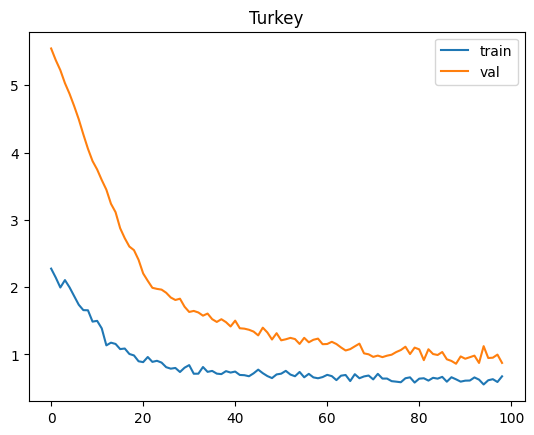

Australia
Epoch 0: train loss 3.8224, val loss 8.8772, time 0.1584
Epoch 1: train loss 3.4923, val loss 8.3850, time 0.1367
Epoch 2: train loss 3.6187, val loss 7.7885, time 0.1380
Epoch 3: train loss 3.3898, val loss 7.1103, time 0.1377
Epoch 4: train loss 2.9071, val loss 6.4600, time 0.1391
Epoch 5: train loss 2.9148, val loss 5.6099, time 0.1358
Epoch 6: train loss 2.5585, val loss 4.8466, time 0.1368
Epoch 7: train loss 2.2612, val loss 4.1285, time 0.1406
Epoch 8: train loss 1.9122, val loss 3.4806, time 0.1493
Epoch 9: train loss 1.7264, val loss 2.9171, time 0.1372
Epoch 10: train loss 1.6227, val loss 2.3843, time 0.1392
Epoch 11: train loss 1.4709, val loss 1.9226, time 0.1384
Epoch 12: train loss 1.4481, val loss 1.6689, time 0.1399
Epoch 13: train loss 1.2813, val loss 1.4960, time 0.1371
Epoch 14: train loss 1.2813, val loss 1.2992, time 0.1395
Epoch 15: train loss 1.2300, val loss 1.2300, time 0.1389
Epoch 16: train loss 1.1854, val loss 1.1338, time 0.1375
Epoch 17: trai

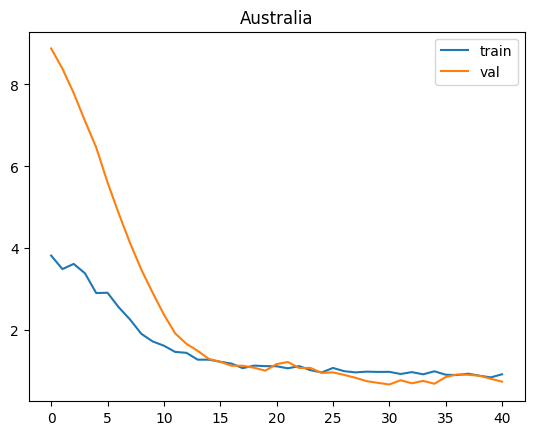

Hawaii
Epoch 0: train loss 2.4438, val loss 2.7153, time 0.1061
Epoch 1: train loss 2.3703, val loss 2.6203, time 0.0921
Epoch 2: train loss 2.2638, val loss 2.5184, time 0.0925
Epoch 3: train loss 2.1966, val loss 2.4063, time 0.0938
Epoch 4: train loss 2.0847, val loss 2.3002, time 0.0946
Epoch 5: train loss 1.9873, val loss 2.2041, time 0.0938
Epoch 6: train loss 1.9367, val loss 2.1014, time 0.0942
Epoch 7: train loss 1.8460, val loss 1.9816, time 0.0922
Epoch 8: train loss 1.7701, val loss 1.8774, time 0.0920
Epoch 9: train loss 1.6808, val loss 1.7770, time 0.0949
Epoch 10: train loss 1.5933, val loss 1.6890, time 0.0927
Epoch 11: train loss 1.5033, val loss 1.6049, time 0.0922
Epoch 12: train loss 1.4573, val loss 1.5272, time 0.0926
Epoch 13: train loss 1.3365, val loss 1.4644, time 0.0918
Epoch 14: train loss 1.2498, val loss 1.4204, time 0.0924
Epoch 15: train loss 1.2587, val loss 1.4229, time 0.0939
Epoch 16: train loss 1.1559, val loss 1.4330, time 0.0939
Epoch 17: train l

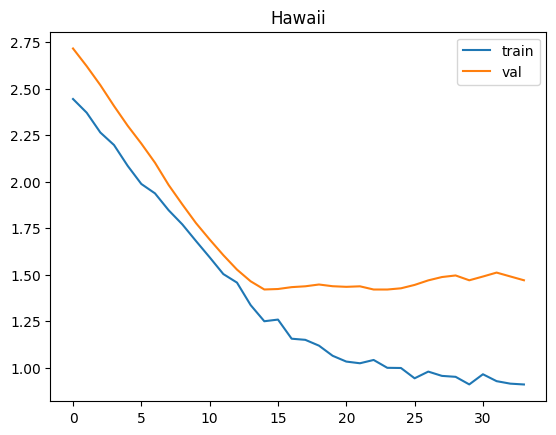

Austria
Epoch 0: train loss 2.7717, val loss 5.4021, time 0.0752
Epoch 1: train loss 2.6014, val loss 5.4173, time 0.0670
Epoch 2: train loss 2.6210, val loss 5.4097, time 0.0666
Epoch 3: train loss 2.6662, val loss 5.3822, time 0.0658
Epoch 4: train loss 2.6399, val loss 5.3948, time 0.0663
Epoch 5: train loss 2.5033, val loss 5.3594, time 0.0670
Epoch 6: train loss 2.5138, val loss 5.3121, time 0.0658
Epoch 7: train loss 2.4947, val loss 5.2269, time 0.0653
Epoch 8: train loss 2.4316, val loss 5.1524, time 0.0663
Epoch 9: train loss 2.3803, val loss 5.0700, time 0.0649
Epoch 10: train loss 2.2980, val loss 4.9836, time 0.0645
Epoch 11: train loss 2.2393, val loss 4.8860, time 0.0645
Epoch 12: train loss 2.2046, val loss 4.7447, time 0.0662
Epoch 13: train loss 2.1559, val loss 4.5413, time 0.0664
Epoch 14: train loss 2.0478, val loss 4.3360, time 0.0662
Epoch 15: train loss 1.9361, val loss 4.1128, time 0.0662
Epoch 16: train loss 1.8271, val loss 3.9252, time 0.0673
Epoch 17: train 

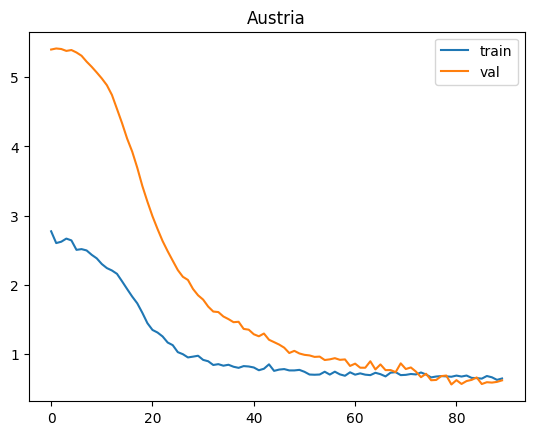

Czech
Epoch 0: train loss 1.9102, val loss 3.6679, time 0.0260
Epoch 1: train loss 1.9222, val loss 3.6279, time 0.0220
Epoch 2: train loss 1.8856, val loss 3.5985, time 0.0221
Epoch 3: train loss 1.9491, val loss 3.5683, time 0.0218
Epoch 4: train loss 1.8591, val loss 3.5371, time 0.0219
Epoch 5: train loss 1.8476, val loss 3.5029, time 0.0225
Epoch 6: train loss 1.8189, val loss 3.4712, time 0.0222
Epoch 7: train loss 1.8516, val loss 3.4381, time 0.0220
Epoch 8: train loss 1.8261, val loss 3.4031, time 0.0219
Epoch 9: train loss 1.8046, val loss 3.3729, time 0.0227
Epoch 10: train loss 1.7555, val loss 3.3380, time 0.0230
Epoch 11: train loss 1.7625, val loss 3.3037, time 0.0222
Epoch 12: train loss 1.6896, val loss 3.2712, time 0.0224
Epoch 13: train loss 1.7098, val loss 3.2414, time 0.0223
Epoch 14: train loss 1.7067, val loss 3.2064, time 0.0228
Epoch 15: train loss 1.6910, val loss 3.1767, time 0.0223
Epoch 16: train loss 1.6487, val loss 3.1409, time 0.0221
Epoch 17: train lo

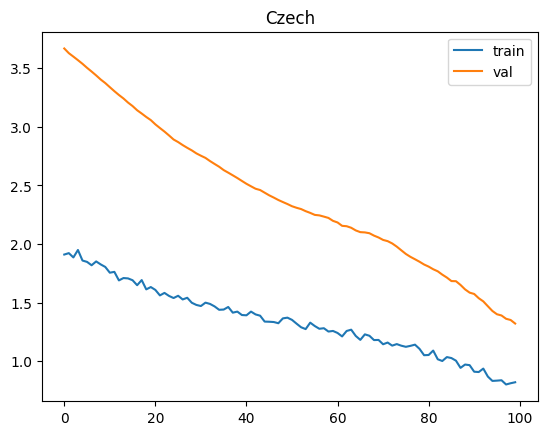

In [75]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=17, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [76]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 323575.33247
RNN Sep R2: 0.87910
RNN Sep MAE: 107790.53889
RNN Sep MAPE: 0.21790
RNN Sep MASE: 2.41849


### Ensemble RNN models

In [78]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.4
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 302474.55317
Weight: 0.1, RMSE: 296272.11309
Weight: 0.2, RMSE: 291860.06555
Weight: 0.3, RMSE: 289320.33099
Weight: 0.4, RMSE: 288702.32625
Weight: 0.5, RMSE: 290018.33672
Weight: 0.6, RMSE: 293242.32518
Weight: 0.7, RMSE: 298312.43707
Weight: 0.8, RMSE: 305136.66142
Weight: 0.9, RMSE: 313600.50601


In [79]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 288702.32625
RNN Ensemble R2: 0.90375
RNN Ensemble MAE: 94801.41409
RNN Ensemble MAPE: 0.20519
RNN Ensemble MASE: 2.17164


# One Hot Temporal Features
### RNN

In [80]:
all_data[country].columns

Index(['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI', 'GDPPerCap',
       'GDP', 'Population', 'TravelPolicy', 'Temperature', 'Precipitation',
       'GlobalCovidTrend', 'DistFromChina', 'Country', 'GDPRatioChina',
       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
       'ChinaGDP', 'VisitorArrivals', 'Popularity', 'Unrest',
       'TravelRestriction', 'Year', 'MonthSin', 'MonthCos', 'Month', 'Month_1',
       'Month_10', 'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9'],
      dtype='object')

In [81]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [82]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

In [83]:
len(country_feat + universal_feat)

29

Epoch 0: train loss 1.9179, val loss 1.2755, time 1.3673
Epoch 1: train loss 0.9482, val loss 1.0881, time 1.1825
Epoch 2: train loss 0.8237, val loss 0.8979, time 1.1874
Epoch 3: train loss 0.7857, val loss 0.9074, time 1.1860
Epoch 4: train loss 0.7717, val loss 0.8709, time 1.1797
Epoch 5: train loss 0.7455, val loss 0.8555, time 1.1863
Epoch 6: train loss 0.7419, val loss 0.8546, time 1.1947
Epoch 7: train loss 0.7400, val loss 0.9115, time 1.1956
Epoch 8: train loss 0.7232, val loss 0.8265, time 1.1870
Epoch 9: train loss 0.7271, val loss 0.8851, time 1.1799
Epoch 10: train loss 0.7226, val loss 0.8331, time 1.1813
Epoch 11: train loss 0.7058, val loss 0.8970, time 1.2729
Epoch 12: train loss 0.7048, val loss 0.9139, time 1.1653
Epoch 13: train loss 0.7114, val loss 0.8404, time 1.1807
Early stopping as no improvement in val loss


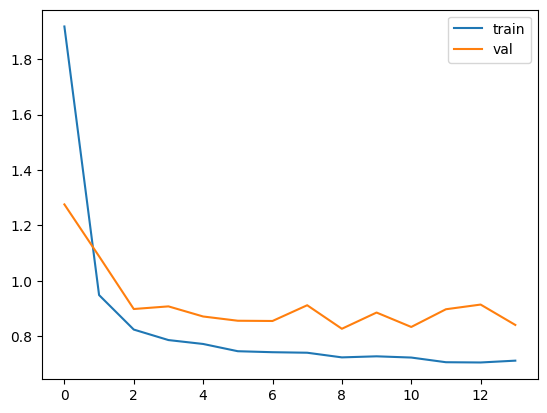

In [85]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=29, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [86]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [87]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [88]:
(all_y == rnn_gt).all()

True

In [89]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 415218.54368
RNN R2: 0.80092
RNN MAE: 117720.47590
RNN MAPE: 0.27256
RNN MASE: 2.69457


## One Step RNN

In [111]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 2.0481, val loss 1.1770, time 1.6394
Epoch 1: train loss 1.0943, val loss 0.9512, time 1.4430
Epoch 2: train loss 0.7421, val loss 0.6625, time 1.4681
Epoch 3: train loss 0.6248, val loss 0.7232, time 1.4403
Epoch 4: train loss 0.6022, val loss 0.6259, time 1.4390
Epoch 5: train loss 0.5590, val loss 0.5423, time 1.4358
Epoch 6: train loss 0.5423, val loss 0.7846, time 1.4527
Epoch 7: train loss 0.5414, val loss 0.5274, time 1.4399
Epoch 8: train loss 0.5262, val loss 0.7161, time 1.4273
Epoch 9: train loss 0.5451, val loss 0.5827, time 1.4323
Epoch 10: train loss 0.5283, val loss 0.4964, time 1.4286
Epoch 11: train loss 0.4982, val loss 0.4780, time 1.4288
Epoch 12: train loss 0.5035, val loss 0.7023, time 1.4409
Epoch 13: train loss 0.5197, val loss 0.6440, time 1.4418
Epoch 14: train loss 0.5117, val loss 0.5206, time 1.4381
Early stopping as no improvement in val loss


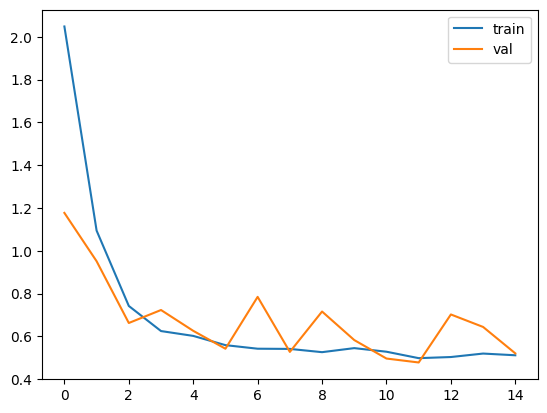

In [112]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=29, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [113]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [114]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [115]:
(rnn_gt == all_y).all()

True

In [116]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 303705.80815
RNN R2: 0.89349
RNN MAE: 93441.65073
RNN MAPE: 0.18646
RNN MASE: 2.20677


### Separate RNN models

In [124]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 2.7983, val loss 5.9803, time 0.0733
Epoch 1: train loss 2.7434, val loss 5.8703, time 0.0631
Epoch 2: train loss 2.6896, val loss 5.7373, time 0.0628
Epoch 3: train loss 2.6114, val loss 5.5959, time 0.0626
Epoch 4: train loss 2.6112, val loss 5.4318, time 0.0644
Epoch 5: train loss 2.5151, val loss 5.2436, time 0.0633
Epoch 6: train loss 2.4434, val loss 5.0387, time 0.0644
Epoch 7: train loss 2.2961, val loss 4.8135, time 0.0644
Epoch 8: train loss 2.2529, val loss 4.5676, time 0.0641
Epoch 9: train loss 2.1399, val loss 4.2781, time 0.0625
Epoch 10: train loss 1.9984, val loss 3.9419, time 0.0625
Epoch 11: train loss 1.9001, val loss 3.5719, time 0.0625
Epoch 12: train loss 1.7203, val loss 3.2001, time 0.0633
Epoch 13: train loss 1.5385, val loss 2.8343, time 0.0623
Epoch 14: train loss 1.3622, val loss 2.4792, time 0.0636
Epoch 15: train loss 1.2765, val loss 2.1750, time 0.0636
Epoch 16: train loss 1.1667, val loss 1.9126, time 0.0643
Epoch 17: train l

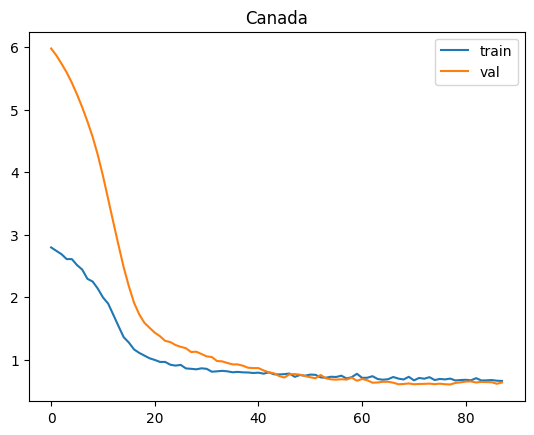

Chile
Epoch 0: train loss 2.2283, val loss 3.0532, time 0.0230
Epoch 1: train loss 2.2328, val loss 3.0448, time 0.0199
Epoch 2: train loss 2.2388, val loss 3.0387, time 0.0200
Epoch 3: train loss 2.2167, val loss 3.0347, time 0.0203
Epoch 4: train loss 2.2192, val loss 3.0293, time 0.0203
Epoch 5: train loss 2.2167, val loss 3.0248, time 0.0204
Epoch 6: train loss 2.2018, val loss 3.0169, time 0.0211
Epoch 7: train loss 2.2178, val loss 3.0146, time 0.0211
Epoch 8: train loss 2.2081, val loss 3.0057, time 0.0204
Epoch 9: train loss 2.2072, val loss 2.9976, time 0.0202
Epoch 10: train loss 2.1858, val loss 2.9897, time 0.0198
Epoch 11: train loss 2.1821, val loss 2.9828, time 0.0201
Epoch 12: train loss 2.1751, val loss 2.9716, time 0.0203
Epoch 13: train loss 2.1760, val loss 2.9629, time 0.0198
Epoch 14: train loss 2.1836, val loss 2.9517, time 0.0200
Epoch 15: train loss 2.1435, val loss 2.9419, time 0.0199
Epoch 16: train loss 2.1136, val loss 2.9277, time 0.0206
Epoch 17: train lo

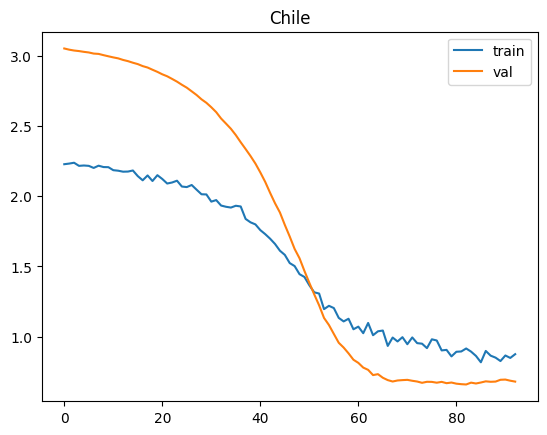

Mexico
Epoch 0: train loss 2.1451, val loss 4.6544, time 0.0614
Epoch 1: train loss 2.4070, val loss 4.5654, time 0.0531
Epoch 2: train loss 1.9885, val loss 4.4713, time 0.0535
Epoch 3: train loss 1.9181, val loss 4.3808, time 0.0524
Epoch 4: train loss 2.0273, val loss 4.2671, time 0.0568
Epoch 5: train loss 2.0932, val loss 4.1523, time 0.0606
Epoch 6: train loss 2.0227, val loss 4.0050, time 0.0508
Epoch 7: train loss 1.9523, val loss 3.8763, time 0.0511
Epoch 8: train loss 1.9927, val loss 3.7314, time 0.0530
Epoch 9: train loss 1.9285, val loss 3.5835, time 0.0520
Epoch 10: train loss 1.7790, val loss 3.4382, time 0.0515
Epoch 11: train loss 1.4591, val loss 3.2876, time 0.0512
Epoch 12: train loss 1.5845, val loss 3.0219, time 0.0508
Epoch 13: train loss 1.5268, val loss 2.7418, time 0.0508
Epoch 14: train loss 1.4367, val loss 2.4690, time 0.0507
Epoch 15: train loss 1.2185, val loss 2.2498, time 0.0504
Epoch 16: train loss 1.1324, val loss 2.0400, time 0.0520
Epoch 17: train l

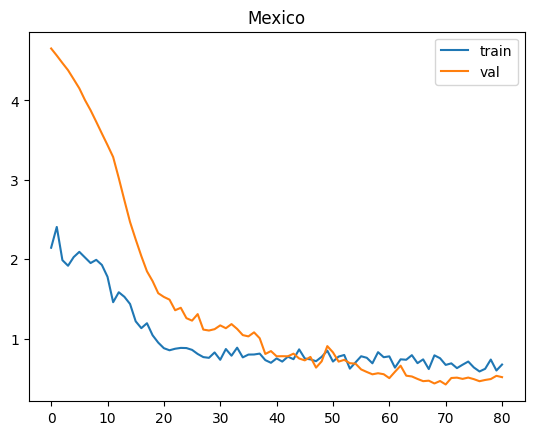

Chinese Taipei
Epoch 0: train loss 0.9643, val loss 1.4585, time 0.0385
Epoch 1: train loss 0.9215, val loss 1.4503, time 0.0349
Epoch 2: train loss 0.9248, val loss 1.4404, time 0.0341
Epoch 3: train loss 0.9055, val loss 1.4263, time 0.0333
Epoch 4: train loss 0.9190, val loss 1.4154, time 0.0329
Epoch 5: train loss 0.9292, val loss 1.4042, time 0.0327
Epoch 6: train loss 0.8230, val loss 1.3878, time 0.0334
Epoch 7: train loss 0.8448, val loss 1.3715, time 0.0329
Epoch 8: train loss 0.8618, val loss 1.3522, time 0.0328
Epoch 9: train loss 0.8141, val loss 1.3247, time 0.0337
Epoch 10: train loss 0.7951, val loss 1.3067, time 0.0327
Epoch 11: train loss 0.8049, val loss 1.2855, time 0.0327
Epoch 12: train loss 0.7734, val loss 1.2553, time 0.0332
Epoch 13: train loss 0.7581, val loss 1.2324, time 0.0336
Epoch 14: train loss 0.6937, val loss 1.2087, time 0.0334
Epoch 15: train loss 0.7361, val loss 1.1892, time 0.0340
Epoch 16: train loss 0.6793, val loss 1.1723, time 0.0335
Epoch 17:

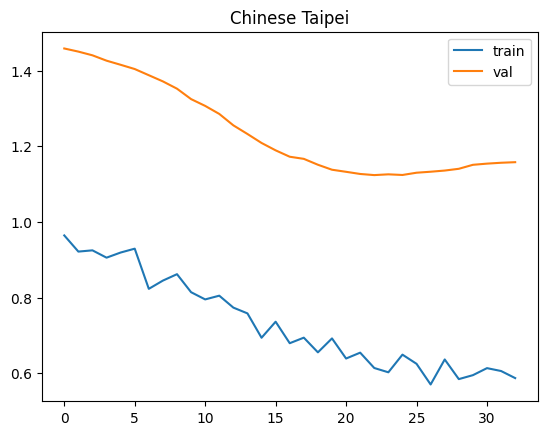

Hong Kong SAR
Epoch 0: train loss 3.0319, val loss 5.0723, time 0.0852
Epoch 1: train loss 3.1252, val loss 4.8537, time 0.0716
Epoch 2: train loss 2.9511, val loss 4.6027, time 0.0718
Epoch 3: train loss 2.7608, val loss 4.3267, time 0.0721
Epoch 4: train loss 2.8688, val loss 3.9797, time 0.0714
Epoch 5: train loss 2.6435, val loss 3.6266, time 0.0716
Epoch 6: train loss 2.6825, val loss 3.2334, time 0.0726
Epoch 7: train loss 2.3366, val loss 2.8636, time 0.0737
Epoch 8: train loss 2.1293, val loss 2.5363, time 0.0717
Epoch 9: train loss 1.9182, val loss 2.3102, time 0.0724
Epoch 10: train loss 1.7209, val loss 2.1527, time 0.0716
Epoch 11: train loss 1.6174, val loss 1.9957, time 0.0712
Epoch 12: train loss 1.5272, val loss 1.8503, time 0.0720
Epoch 13: train loss 1.3650, val loss 1.7901, time 0.0724
Epoch 14: train loss 1.1903, val loss 1.7556, time 0.0723
Epoch 15: train loss 1.1450, val loss 1.7299, time 0.0728
Epoch 16: train loss 0.9893, val loss 1.7167, time 0.0716
Epoch 17: 

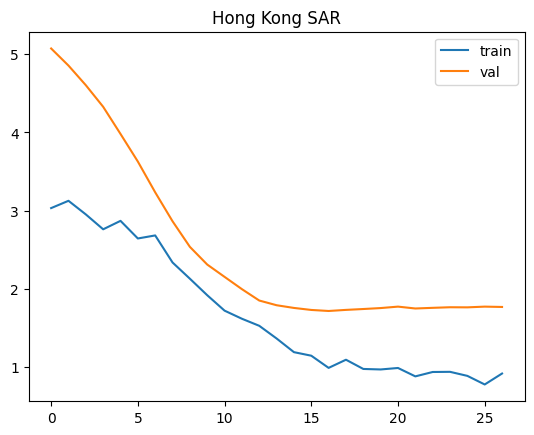

Japan
Epoch 0: train loss 4.8338, val loss 8.3013, time 0.0919
Epoch 1: train loss 4.5627, val loss 8.1997, time 0.0811
Epoch 2: train loss 4.3969, val loss 8.0823, time 0.0806
Epoch 3: train loss 4.3751, val loss 7.9438, time 0.0807
Epoch 4: train loss 4.0978, val loss 7.7948, time 0.0789
Epoch 5: train loss 3.9501, val loss 7.6091, time 0.0789
Epoch 6: train loss 3.7327, val loss 7.3947, time 0.0796
Epoch 7: train loss 3.6124, val loss 7.1595, time 0.0814
Epoch 8: train loss 3.3390, val loss 6.8895, time 0.0806
Epoch 9: train loss 3.1795, val loss 6.5955, time 0.0810
Epoch 10: train loss 2.8627, val loss 6.3106, time 0.0803
Epoch 11: train loss 2.6674, val loss 6.0335, time 0.1020
Epoch 12: train loss 2.5073, val loss 5.7636, time 0.0865
Epoch 13: train loss 2.2991, val loss 5.5222, time 0.0854
Epoch 14: train loss 2.2773, val loss 5.3063, time 0.0846
Epoch 15: train loss 2.1439, val loss 5.0875, time 0.0850
Epoch 16: train loss 2.0936, val loss 4.8906, time 0.0844
Epoch 17: train lo

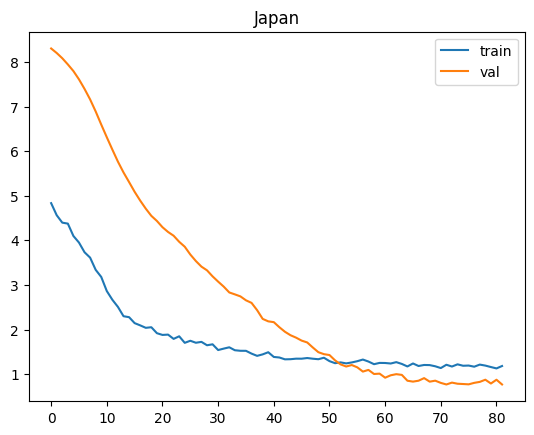

Korea (ROK)
Epoch 0: train loss 3.3556, val loss 5.3161, time 0.0937
Epoch 1: train loss 3.3081, val loss 5.1920, time 0.0815
Epoch 2: train loss 3.2170, val loss 5.0548, time 0.0811
Epoch 3: train loss 3.0970, val loss 4.9081, time 0.0806
Epoch 4: train loss 3.0782, val loss 4.7305, time 0.0794
Epoch 5: train loss 2.9495, val loss 4.5478, time 0.0793
Epoch 6: train loss 2.8186, val loss 4.3321, time 0.0811
Epoch 7: train loss 2.7455, val loss 4.0773, time 0.0808
Epoch 8: train loss 2.5748, val loss 3.7953, time 0.0800
Epoch 9: train loss 2.3770, val loss 3.4868, time 0.0811
Epoch 10: train loss 2.2329, val loss 3.1543, time 0.0797
Epoch 11: train loss 2.0273, val loss 2.7939, time 0.0794
Epoch 12: train loss 1.7881, val loss 2.4753, time 0.0812
Epoch 13: train loss 1.6425, val loss 2.1775, time 0.0807
Epoch 14: train loss 1.4988, val loss 1.9156, time 0.0779
Epoch 15: train loss 1.4157, val loss 1.6587, time 0.0772
Epoch 16: train loss 1.2792, val loss 1.4658, time 0.0765
Epoch 17: tr

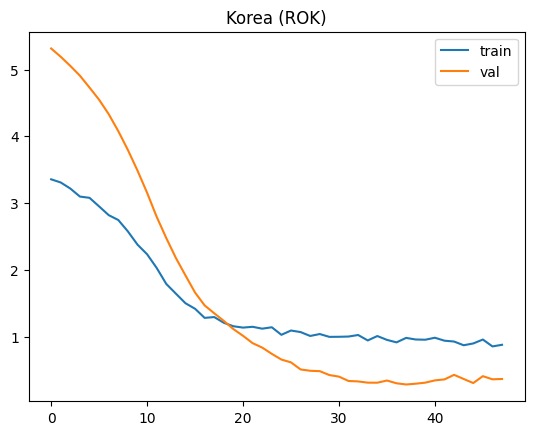

Macao, China
Epoch 0: train loss 2.0403, val loss 4.9307, time 0.0885
Epoch 1: train loss 1.8664, val loss 4.8155, time 0.0752
Epoch 2: train loss 1.8445, val loss 4.6780, time 0.0734
Epoch 3: train loss 1.7767, val loss 4.5262, time 0.0748
Epoch 4: train loss 1.8289, val loss 4.3213, time 0.0745
Epoch 5: train loss 1.7988, val loss 4.0987, time 0.0785
Epoch 6: train loss 1.6436, val loss 3.8495, time 0.0930
Epoch 7: train loss 1.5835, val loss 3.5604, time 0.0779
Epoch 8: train loss 1.3823, val loss 3.2575, time 0.0783
Epoch 9: train loss 1.2702, val loss 2.9434, time 0.0797
Epoch 10: train loss 1.1967, val loss 2.6280, time 0.0810
Epoch 11: train loss 1.0938, val loss 2.3671, time 0.0806
Epoch 12: train loss 1.0405, val loss 2.1174, time 0.0952
Epoch 13: train loss 0.9988, val loss 1.8710, time 0.0762
Epoch 14: train loss 0.9165, val loss 1.7048, time 0.0947
Epoch 15: train loss 0.9021, val loss 1.5311, time 0.0922
Epoch 16: train loss 0.8229, val loss 1.3808, time 0.0772
Epoch 17: t

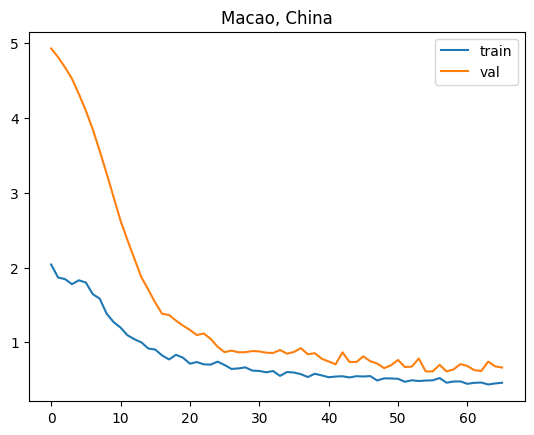

Maldives
Epoch 0: train loss 2.5259, val loss 4.0248, time 0.0923
Epoch 1: train loss 2.5099, val loss 3.9022, time 0.0801
Epoch 2: train loss 2.5023, val loss 3.7547, time 0.0822
Epoch 3: train loss 2.3881, val loss 3.6043, time 0.0811
Epoch 4: train loss 2.3850, val loss 3.4161, time 0.0792
Epoch 5: train loss 2.3255, val loss 3.2136, time 0.0785
Epoch 6: train loss 2.2500, val loss 2.9536, time 0.0794
Epoch 7: train loss 2.1082, val loss 2.6795, time 0.0794
Epoch 8: train loss 2.0049, val loss 2.4416, time 0.0804
Epoch 9: train loss 1.8248, val loss 2.1796, time 0.0832
Epoch 10: train loss 1.6633, val loss 1.8706, time 0.0828
Epoch 11: train loss 1.5069, val loss 1.5469, time 0.0809
Epoch 12: train loss 1.3093, val loss 1.2548, time 0.0777
Epoch 13: train loss 1.1814, val loss 0.9932, time 0.0757
Epoch 14: train loss 1.1202, val loss 0.8593, time 0.0757
Epoch 15: train loss 1.0073, val loss 0.7227, time 0.0778
Epoch 16: train loss 0.9678, val loss 0.6283, time 0.0794
Epoch 17: train

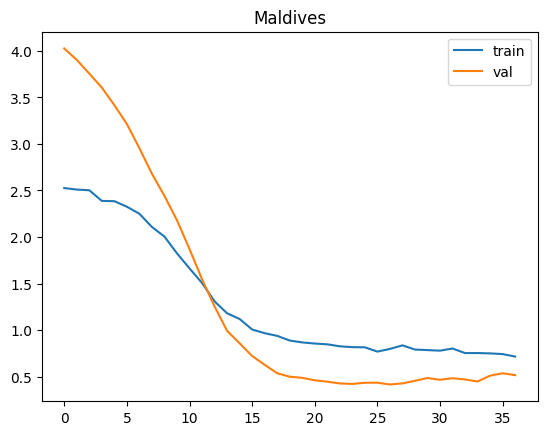

Cambodia
Epoch 0: train loss 3.0385, val loss 7.9733, time 0.0834
Epoch 1: train loss 2.9269, val loss 7.8036, time 0.0583
Epoch 2: train loss 2.9426, val loss 7.6017, time 0.0576
Epoch 3: train loss 2.7667, val loss 7.3911, time 0.0730
Epoch 4: train loss 2.7265, val loss 7.1698, time 0.0605
Epoch 5: train loss 2.6481, val loss 6.9051, time 0.0584
Epoch 6: train loss 2.4815, val loss 6.6560, time 0.0589
Epoch 7: train loss 2.4626, val loss 6.3526, time 0.0611
Epoch 8: train loss 2.2576, val loss 6.0485, time 0.0683
Epoch 9: train loss 2.1347, val loss 5.7482, time 0.0585
Epoch 10: train loss 1.9237, val loss 5.4533, time 0.0582
Epoch 11: train loss 1.7751, val loss 5.1943, time 0.0581
Epoch 12: train loss 1.7452, val loss 4.9144, time 0.0594
Epoch 13: train loss 1.5887, val loss 4.6351, time 0.0578
Epoch 14: train loss 1.5353, val loss 4.3668, time 0.0592
Epoch 15: train loss 1.4077, val loss 4.1644, time 0.0590
Epoch 16: train loss 1.2942, val loss 3.9510, time 0.0599
Epoch 17: train

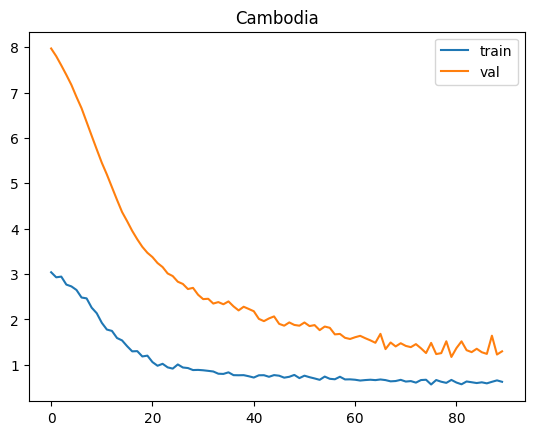

Indonesia
Epoch 0: train loss 1.4245, val loss 2.0581, time 0.0183
Epoch 1: train loss 1.3974, val loss 2.0237, time 0.0156
Epoch 2: train loss 1.3491, val loss 1.9982, time 0.0156
Epoch 3: train loss 1.3543, val loss 1.9695, time 0.0155
Epoch 4: train loss 1.3420, val loss 1.9423, time 0.0155
Epoch 5: train loss 1.3576, val loss 1.9143, time 0.0152
Epoch 6: train loss 1.3339, val loss 1.8859, time 0.0155
Epoch 7: train loss 1.2865, val loss 1.8590, time 0.0152
Epoch 8: train loss 1.3165, val loss 1.8311, time 0.0154
Epoch 9: train loss 1.3222, val loss 1.8011, time 0.0167
Epoch 10: train loss 1.2820, val loss 1.7756, time 0.0155
Epoch 11: train loss 1.2328, val loss 1.7506, time 0.0156
Epoch 12: train loss 1.2589, val loss 1.7250, time 0.0155
Epoch 13: train loss 1.2336, val loss 1.6984, time 0.0164
Epoch 14: train loss 1.1823, val loss 1.6673, time 0.0152
Epoch 15: train loss 1.1676, val loss 1.6444, time 0.0154
Epoch 16: train loss 1.1655, val loss 1.6212, time 0.0155
Epoch 17: trai

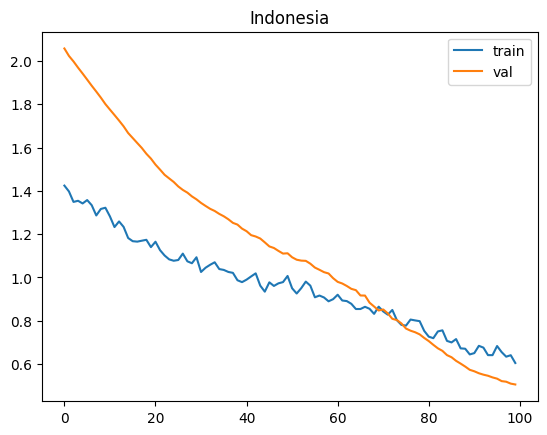

Singapore
Epoch 0: train loss 1.2492, val loss 3.4821, time 0.0735
Epoch 1: train loss 1.2555, val loss 3.4446, time 0.0639
Epoch 2: train loss 1.2104, val loss 3.4032, time 0.0631
Epoch 3: train loss 1.1967, val loss 3.3589, time 0.0623
Epoch 4: train loss 1.1785, val loss 3.3074, time 0.0639
Epoch 5: train loss 1.1633, val loss 3.2501, time 0.0650
Epoch 6: train loss 1.1325, val loss 3.1864, time 0.0621
Epoch 7: train loss 1.1126, val loss 3.1126, time 0.0619
Epoch 8: train loss 1.0650, val loss 3.0281, time 0.0632
Epoch 9: train loss 1.0451, val loss 2.9318, time 0.0626
Epoch 10: train loss 1.0066, val loss 2.8223, time 0.0620
Epoch 11: train loss 0.9673, val loss 2.7020, time 0.0615
Epoch 12: train loss 0.9530, val loss 2.5704, time 0.0623
Epoch 13: train loss 0.8903, val loss 2.4263, time 0.0649
Epoch 14: train loss 0.8497, val loss 2.2728, time 0.0626
Epoch 15: train loss 0.8076, val loss 2.1210, time 0.0620
Epoch 16: train loss 0.7851, val loss 1.9780, time 0.0626
Epoch 17: trai

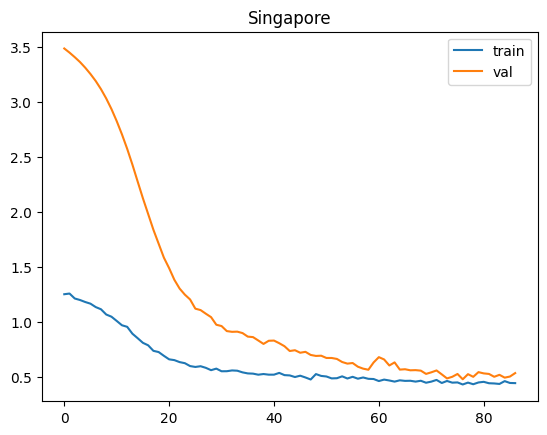

New Zealand
Epoch 0: train loss 1.8611, val loss 3.9391, time 0.0726
Epoch 1: train loss 1.8586, val loss 3.8653, time 0.0627
Epoch 2: train loss 1.8331, val loss 3.7833, time 0.0627
Epoch 3: train loss 1.7995, val loss 3.6845, time 0.0620
Epoch 4: train loss 1.7689, val loss 3.5762, time 0.0631
Epoch 5: train loss 1.7112, val loss 3.4621, time 0.0622
Epoch 6: train loss 1.6396, val loss 3.3260, time 0.0620
Epoch 7: train loss 1.5837, val loss 3.1705, time 0.0619
Epoch 8: train loss 1.5368, val loss 3.0074, time 0.0630
Epoch 9: train loss 1.4693, val loss 2.8293, time 0.0631
Epoch 10: train loss 1.4283, val loss 2.6269, time 0.0626
Epoch 11: train loss 1.3249, val loss 2.4227, time 0.0686
Epoch 12: train loss 1.2587, val loss 2.2139, time 0.0638
Epoch 13: train loss 1.1515, val loss 2.0016, time 0.0624
Epoch 14: train loss 1.0810, val loss 1.8076, time 0.0618
Epoch 15: train loss 0.9967, val loss 1.6269, time 0.0621
Epoch 16: train loss 0.9516, val loss 1.4442, time 0.0651
Epoch 17: tr

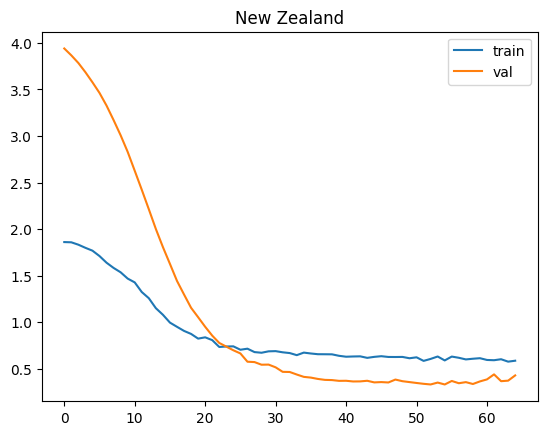

USA
Epoch 0: train loss 4.4804, val loss 6.7736, time 0.0873
Epoch 1: train loss 3.8238, val loss 6.6254, time 0.0744
Epoch 2: train loss 3.7716, val loss 6.4398, time 0.0750
Epoch 3: train loss 3.4591, val loss 6.2477, time 0.0747
Epoch 4: train loss 3.7219, val loss 6.0290, time 0.0734
Epoch 5: train loss 4.1495, val loss 5.8173, time 0.0703
Epoch 6: train loss 2.9812, val loss 5.6021, time 0.0725
Epoch 7: train loss 3.1741, val loss 5.3891, time 0.0707
Epoch 8: train loss 2.6120, val loss 5.1611, time 0.0727
Epoch 9: train loss 2.7033, val loss 4.9353, time 0.0748
Epoch 10: train loss 3.3636, val loss 4.6936, time 0.0734
Epoch 11: train loss 3.1479, val loss 4.4100, time 0.0737
Epoch 12: train loss 2.8535, val loss 4.1341, time 0.0744
Epoch 13: train loss 3.0006, val loss 3.7518, time 0.0756
Epoch 14: train loss 2.0683, val loss 3.4665, time 0.0751
Epoch 15: train loss 2.4550, val loss 3.0843, time 0.0752
Epoch 16: train loss 1.6526, val loss 2.8044, time 0.0742
Epoch 17: train loss

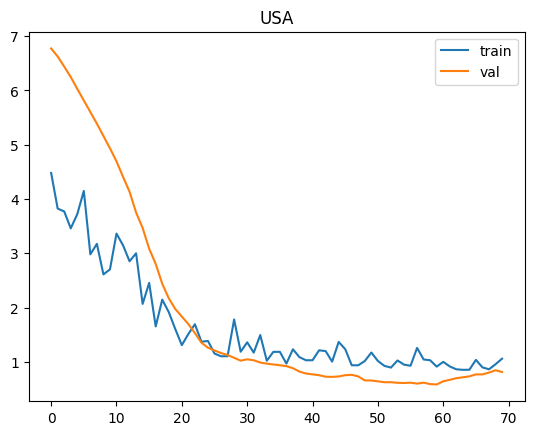

Thailand
Epoch 0: train loss 2.5488, val loss 5.6749, time 0.1038
Epoch 1: train loss 2.4823, val loss 5.5907, time 0.0884
Epoch 2: train loss 2.3997, val loss 5.4863, time 0.0887
Epoch 3: train loss 2.3023, val loss 5.3564, time 0.1139
Epoch 4: train loss 2.2203, val loss 5.2069, time 0.0898
Epoch 5: train loss 2.1155, val loss 5.0132, time 0.0874
Epoch 6: train loss 2.0160, val loss 4.7874, time 0.0902
Epoch 7: train loss 1.9123, val loss 4.5221, time 0.0884
Epoch 8: train loss 1.7962, val loss 4.2222, time 0.0905
Epoch 9: train loss 1.6828, val loss 3.8875, time 0.0889
Epoch 10: train loss 1.5703, val loss 3.5383, time 0.0879
Epoch 11: train loss 1.4475, val loss 3.1946, time 0.0877
Epoch 12: train loss 1.3504, val loss 2.8847, time 0.0890
Epoch 13: train loss 1.2861, val loss 2.6280, time 0.0882
Epoch 14: train loss 1.2182, val loss 2.4345, time 0.0902
Epoch 15: train loss 1.1836, val loss 2.2887, time 0.0883
Epoch 16: train loss 1.1701, val loss 2.1402, time 0.0890
Epoch 17: train

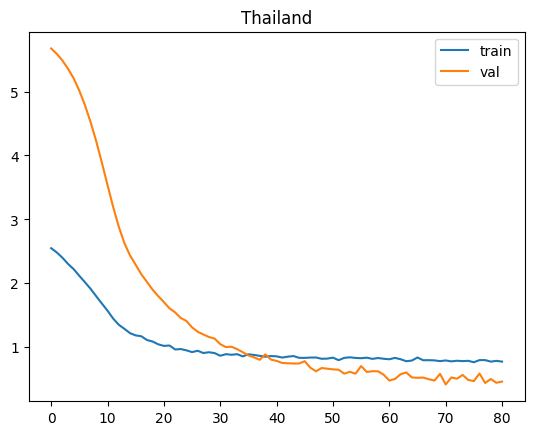

Turkey
Epoch 0: train loss 2.2606, val loss 5.5814, time 0.0867
Epoch 1: train loss 2.0557, val loss 5.4698, time 0.0754
Epoch 2: train loss 1.9620, val loss 5.3448, time 0.0746
Epoch 3: train loss 1.8621, val loss 5.2089, time 0.0756
Epoch 4: train loss 1.8696, val loss 5.0489, time 0.0743
Epoch 5: train loss 1.7383, val loss 4.8815, time 0.0745
Epoch 6: train loss 1.7423, val loss 4.6961, time 0.0757
Epoch 7: train loss 1.5487, val loss 4.5011, time 0.0761
Epoch 8: train loss 1.5167, val loss 4.2640, time 0.0759
Epoch 9: train loss 1.4395, val loss 4.0197, time 0.0765
Epoch 10: train loss 1.2595, val loss 3.7553, time 0.0747
Epoch 11: train loss 1.3037, val loss 3.4442, time 0.0743
Epoch 12: train loss 1.3125, val loss 3.2041, time 0.0761
Epoch 13: train loss 1.1234, val loss 2.9891, time 0.0757
Epoch 14: train loss 1.0245, val loss 2.7786, time 0.0752
Epoch 15: train loss 1.0437, val loss 2.5182, time 0.0769
Epoch 16: train loss 0.9693, val loss 2.2790, time 0.0755
Epoch 17: train l

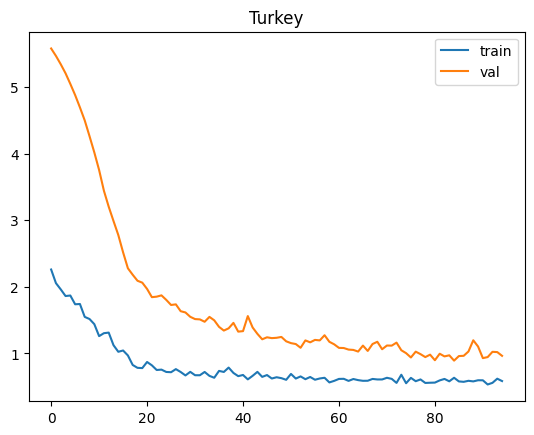

Australia
Epoch 0: train loss 3.6514, val loss 7.9401, time 0.1384
Epoch 1: train loss 3.3544, val loss 7.5613, time 0.1204
Epoch 2: train loss 3.3804, val loss 7.0896, time 0.1229
Epoch 3: train loss 3.1180, val loss 6.5692, time 0.1204
Epoch 4: train loss 2.7836, val loss 6.0095, time 0.1200
Epoch 5: train loss 2.5586, val loss 5.4058, time 0.1222
Epoch 6: train loss 2.3544, val loss 4.7658, time 0.1222
Epoch 7: train loss 2.2044, val loss 4.1292, time 0.1194
Epoch 8: train loss 1.8624, val loss 3.6031, time 0.1200
Epoch 9: train loss 1.5996, val loss 3.1679, time 0.1217
Epoch 10: train loss 1.5750, val loss 2.7041, time 0.1207
Epoch 11: train loss 1.4457, val loss 2.4484, time 0.1194
Epoch 12: train loss 1.3195, val loss 2.2903, time 0.1196
Epoch 13: train loss 1.2886, val loss 1.9754, time 0.1205
Epoch 14: train loss 1.3011, val loss 1.7621, time 0.1223
Epoch 15: train loss 1.2556, val loss 1.6726, time 0.1194
Epoch 16: train loss 1.1474, val loss 1.4723, time 0.1195
Epoch 17: trai

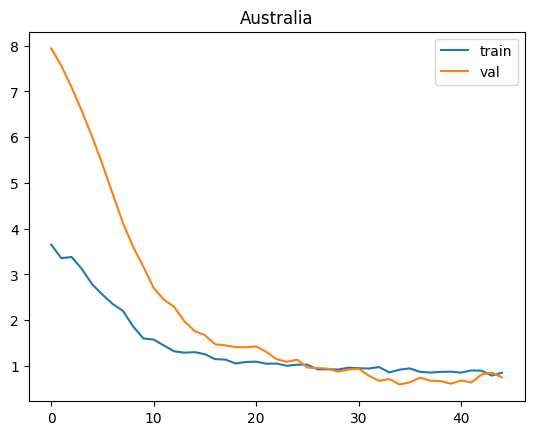

Hawaii
Epoch 0: train loss 2.4394, val loss 2.6944, time 0.0982
Epoch 1: train loss 2.3941, val loss 2.6185, time 0.0865
Epoch 2: train loss 2.2657, val loss 2.5340, time 0.0896
Epoch 3: train loss 2.2469, val loss 2.4308, time 0.0865
Epoch 4: train loss 2.2253, val loss 2.3067, time 0.0859
Epoch 5: train loss 2.1156, val loss 2.1743, time 0.0858
Epoch 6: train loss 2.0249, val loss 2.0278, time 0.0870
Epoch 7: train loss 1.9658, val loss 1.8624, time 0.0848
Epoch 8: train loss 1.9015, val loss 1.6768, time 0.0848
Epoch 9: train loss 1.8114, val loss 1.5176, time 0.0852
Epoch 10: train loss 1.7309, val loss 1.3707, time 0.0867
Epoch 11: train loss 1.6251, val loss 1.2460, time 0.0801
Epoch 12: train loss 1.4774, val loss 1.1817, time 0.0808
Epoch 13: train loss 1.3734, val loss 1.1474, time 0.0795
Epoch 14: train loss 1.3023, val loss 1.1005, time 0.0813
Epoch 15: train loss 1.2634, val loss 1.0812, time 0.0813
Epoch 16: train loss 1.1626, val loss 1.0340, time 0.0894
Epoch 17: train l

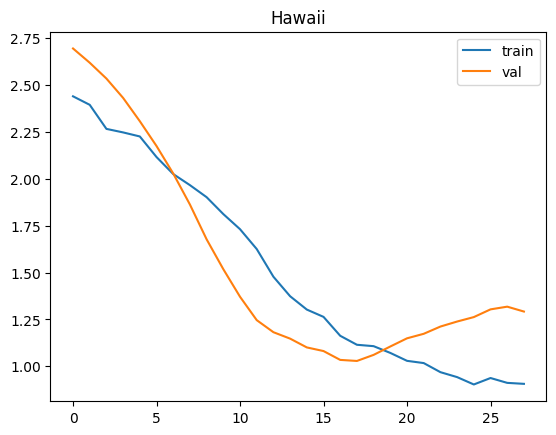

Austria
Epoch 0: train loss 2.5072, val loss 5.8010, time 0.0668
Epoch 1: train loss 2.4973, val loss 5.6881, time 0.0605
Epoch 2: train loss 2.4719, val loss 5.5577, time 0.0576
Epoch 3: train loss 2.3410, val loss 5.4266, time 0.0571
Epoch 4: train loss 2.2785, val loss 5.2572, time 0.0599
Epoch 5: train loss 2.1963, val loss 5.0689, time 0.0568
Epoch 6: train loss 2.2685, val loss 4.8376, time 0.0564
Epoch 7: train loss 2.0946, val loss 4.5903, time 0.0719
Epoch 8: train loss 1.9690, val loss 4.3205, time 0.0580
Epoch 9: train loss 1.8204, val loss 4.0425, time 0.0573
Epoch 10: train loss 1.7039, val loss 3.7550, time 0.0580
Epoch 11: train loss 1.6420, val loss 3.4450, time 0.0572
Epoch 12: train loss 1.5364, val loss 3.1715, time 0.0575
Epoch 13: train loss 1.4137, val loss 2.9339, time 0.0573
Epoch 14: train loss 1.3160, val loss 2.7133, time 0.0574
Epoch 15: train loss 1.2082, val loss 2.5464, time 0.0566
Epoch 16: train loss 1.1435, val loss 2.3797, time 0.0576
Epoch 17: train 

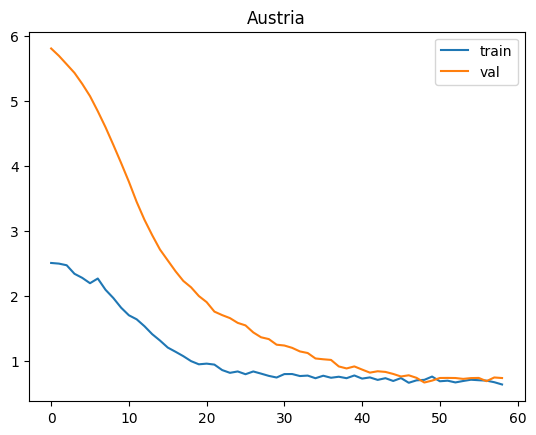

Czech
Epoch 0: train loss 1.6195, val loss 3.1998, time 0.0232
Epoch 1: train loss 1.5893, val loss 3.1713, time 0.0196
Epoch 2: train loss 1.5758, val loss 3.1442, time 0.0197
Epoch 3: train loss 1.5910, val loss 3.1196, time 0.0194
Epoch 4: train loss 1.5609, val loss 3.0956, time 0.0191
Epoch 5: train loss 1.5157, val loss 3.0699, time 0.0189
Epoch 6: train loss 1.5119, val loss 3.0419, time 0.0200
Epoch 7: train loss 1.5332, val loss 3.0169, time 0.0188
Epoch 8: train loss 1.5211, val loss 2.9906, time 0.0191
Epoch 9: train loss 1.4847, val loss 2.9623, time 0.0192
Epoch 10: train loss 1.4982, val loss 2.9362, time 0.0192
Epoch 11: train loss 1.4393, val loss 2.9057, time 0.0194
Epoch 12: train loss 1.4647, val loss 2.8770, time 0.0197
Epoch 13: train loss 1.4469, val loss 2.8474, time 0.0195
Epoch 14: train loss 1.4184, val loss 2.8221, time 0.0193
Epoch 15: train loss 1.4248, val loss 2.7921, time 0.0193
Epoch 16: train loss 1.4011, val loss 2.7631, time 0.0194
Epoch 17: train lo

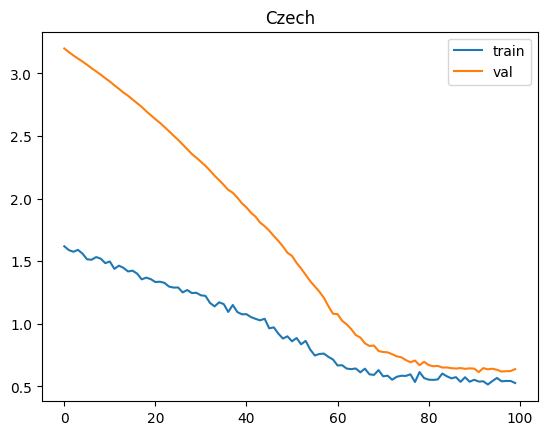

In [142]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=28, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [143]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 276752.47531
RNN Sep R2: 0.91156
RNN Sep MAE: 93658.52959
RNN Sep MAPE: 0.18397
RNN Sep MASE: 2.05913


### Ensemble RNN models

In [144]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.5
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 303705.80815
Weight: 0.1, RMSE: 292062.87166
Weight: 0.2, RMSE: 282060.26811
Weight: 0.3, RMSE: 273877.78194
Weight: 0.4, RMSE: 267682.37668
Weight: 0.5, RMSE: 263614.18945
Weight: 0.6, RMSE: 261772.41589
Weight: 0.7, RMSE: 262203.97654
Weight: 0.8, RMSE: 264897.76076
Weight: 0.9, RMSE: 269786.01288


In [145]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 263614.18945
RNN Ensemble R2: 0.91975
RNN Ensemble MAE: 87591.95217
RNN Ensemble MAPE: 0.17614
RNN Ensemble MASE: 2.03554
